In [1672]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn 
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier

#imblearn to balance training data
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from collections import Counter

# XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgb.set_config(verbosity=0) # to supress warnings

# shap
import shap

#joblib to save trained models
import joblib

# Show pipelines as interactive diagram
from sklearn import set_config; set_config(display='diagram')

In [1673]:
# Set random seed for reproducibility reasons
np.random.seed(42)

In [1674]:
import sklearn, imblearn, matplotlib
print("Installed/ Used versions:")
print("python: 3.8.6")
print("sklearn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)
print("shap:", shap.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("xgb:", xgb.__version__)
print("joblib:", joblib.__version__)

Installed/ Used versions:
python: 3.8.6
sklearn: 1.0.2
imblearn: 0.9.0
shap: 0.40.0
numpy: 1.20.3
pandas: 1.3.5
matplotlib: 3.2.2
seaborn: 0.11.2
xgb: 1.4.2
joblib: 1.1.0


# Create clean dataframe


## Load dataset

In [1675]:
df = pd.read_csv("../../data-cleaned/compas-scores-two-years-clean.csv")

## Filter dataset

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [1676]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

- Since most of the columns in the dataset describe charges after the initial COMPAS screening. Therefore these columns can not be used as predictors. 
- Furthermore we compared the original questionaire for the COMPAS scoring with the data of our datasets: 
- From the X sections in the original questionaire we only have data about demographics, criminal history and current charges from the defendant. 

In [1677]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant fro feature engineering)
           "two_year_recid"] #target for classification 
df_clean = df[columns]

In [1678]:
# Drop duplicates (there are none, but for completness we introduce the step anyhow)
df_clean = df_clean.drop_duplicates()

## Check missing values and dtypes

In [1679]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


- Some columns contain null values, but out of these only `c_charge_desc`will be relevant for modeling, since the other columns contain data which was generated after the COMPAS screening, an thus can not be used 
- The imputing of missing values will be performed during the preprocessing 

## Check outliers

In [1680]:
df_clean[["age", 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']].describe()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,5304.000000,5304.000000,5304.000000,5304.000000,5304.000000
mean,34.953431,0.052036,0.088047,0.101433,2.993590
std,11.817771,0.382938,0.511951,0.448231,4.458153
min,19.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,0.000000,0.000000,0.000000,1.000000
75%,43.000000,0.000000,0.000000,0.000000,4.000000
max,96.000000,10.000000,13.000000,9.000000,37.000000


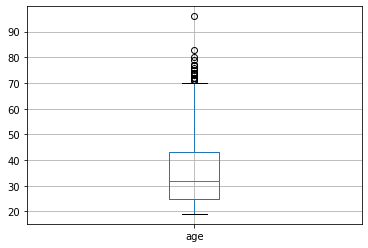

In [1681]:
df_clean[["age"]].boxplot();

In [1682]:
print(f"There are {df_clean[df_clean['age']>70].shape[0]} defendants who are older than 70 years")
print("Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed")

There are 22 defendants who are older than 70 years
Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed


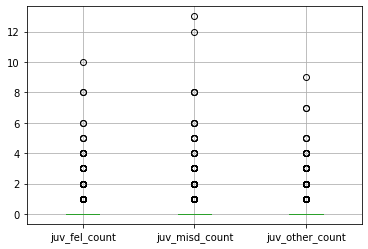

In [1683]:
df_clean[['juv_fel_count', 'juv_misd_count', 'juv_other_count']].boxplot();

In [1684]:
print(f"Defendants with >0 juv_fel_count: {df_clean[df_clean['juv_fel_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_fel_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_misd_count: {df_clean[df_clean['juv_misd_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_misd_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_other_count: {df_clean[df_clean['juv_other_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_other_count']>0].shape[0]/df_clean.shape[0],2)}%")

Defendants with >0 juv_fel_count: 164, 0.03%
Defendants with >0 juv_misd_count: 277, 0.05%
Defendants with >0 juv_other_count: 368, 0.07%


- The vast majority of defendants in this dataset has no criminal juvenile records. 
- Even though the numbers are relatively small, there is no indication that there was an error in creating the dataset
- These repeated juvenile offenders seem to be rare, but valid "outliers" and thus should not be removed!

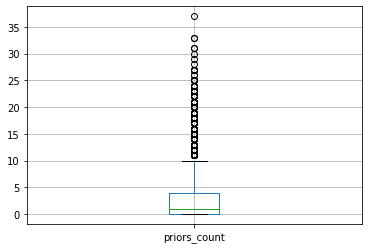

In [1685]:
df_clean[['priors_count']].boxplot();

In [1686]:
print(f"Defendants with >10 priors: {df_clean[df_clean['priors_count']>10].shape[0]}, \
{np.round(df_clean[df_clean['priors_count']>10].shape[0]/df_clean.shape[0],2)}%")

Defendants with >10 priors: 365, 0.07%


There are 365 defendants with more than 10 priors. Nevertheless these repeated offenders seem to be rare, but valid "outliers" and thus should not be removed!

## Scoring

### Choose scoring metrics

**Classification**

In [1687]:
#Checking class distribution target y
df_clean.two_year_recid.value_counts()

0    3363
1    1941
Name: two_year_recid, dtype: int64

In [1688]:
df_clean.two_year_recid.value_counts(normalize=True)

0    0.63405
1    0.36595
Name: two_year_recid, dtype: float64

We have an uneven class distribution in our target

We will try to predict whether a person will re-offend in the following two years or not. 
- The cost of false positives (predict that someone will re-offend, but did not) is high for the defendant, since the person will probably stay in custody until trial. 
- The cost of false negatives (predict that someone will not re-offend, but did) is high for society since most crimes include a victim



In [1689]:
clf_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss']

---
**Regression**

### Create functions for storing results from cross validation and GridSearch

- We will store the cross validated and GridSearch results as well as the model name
- This will be used in the end to compare the different estimators and select the best model

In [1690]:
# List for cross validated models (no GridSearch)
cv_results_list=[]
cv_models_list=[]

# List for cross validated models using GridSearch
grid_results_list=[]
grid_models_list=[]

# Dictonary of trained models
dict_models = {}

In [1691]:
def save_cv_results(cv_results_list, model_name_list):
    '''Store cv results for all splits and metrics as a list of df'''
    cv_results_df=[]
    
    for i, cv_results in enumerate(cv_results_list):
    
        cv_results = pd.DataFrame(cv_results)

        # Subsetting cv_results (exclude time metrics)
        time_metrics = ['fit_time','score_time'] # fit time metrics
        cv_results_nofit = cv_results.loc[:,~cv_results.columns.isin(time_metrics)].copy()

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in cv_results_nofit.columns:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            cv_results_nofit["test_neg_log_loss"] = cv_results_nofit["test_neg_log_loss"].abs()
            cv_results_nofit.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
        
        cv_results_nofit["model"]=model_name_list[i]
        cv_results_df.append(cv_results_nofit)
        
    return cv_results_df
    # Create df for plot
    #final_nofit_plot = pd.melt(final_nofit, id_vars=['model'], var_name='metrics', value_name='values')

In [1692]:
def save_grid_cv_results(grid_model_list, model_name_grid_list, scorings):
    '''Store cv results for each split for each metric of GridSearch of best model as list of df'''
    grid_cv_results_df=[]
    
    for i, grid_model in enumerate(grid_model_list):

        # get index of best model 
        indx = grid_model.cv_results_["params"].index(grid_model.best_params_)

        # Filter grid search cv results for best model
        cv_results_grid = {k:v[indx] for (k,v) in grid_model.cv_results_.items() if k.startswith('split')}

        #scoring metrics
        col_dict = ["test_"+x for x in scorings]

        # Creat dict for plotting with results for each split for each metric of GridSearch for best model
        final_dict = {}
        for col in col_dict:
            for (k,v) in cv_results_grid.items():
                if k.endswith(col):
                    final_dict.setdefault(col, []).append(v)

        df_final = pd.DataFrame(final_dict)
        df_final["model"]=model_name_grid_list[i]

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in col_dict:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            df_final["test_neg_log_loss"] = df_final["test_neg_log_loss"].abs()
            df_final.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
    
        grid_cv_results_df.append(df_final)
        
    
    return grid_cv_results_df

In [1693]:
## Function for scoring all models on test set and print results (confusion matrix and boxplot)

# Feature Engineering: Create feature `c_charge_degree_detailed`

- The current charges of the ProPublica dataset are categorized as felonies or misdemeanors `c_charge_degreee``
- The `c_charge_desc` contains the description of the crime (e.g. murder, Grand theft ...)
- In Florida each crime is based on the severness categorised into different level/ classes of misdemeanors or felonies

In [1694]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df_clean.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df_clean[df_clean["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df_clean[df_clean["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
- The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
- We first used these crimes and map them against the current charges 

In [1695]:
# check unique values/ classes of charges 
df_clean.r_charge_degree.unique()

array([nan, '(F3)', '(M1)', '(F2)', '(M2)', '(MO3)', '(F1)', '(F6)',
       '(F7)', '(CO3)', '(F5)'], dtype=object)

In [1696]:
# Create lookup table for c_charge_degree_detailed based on c_charge_desc
lookup_c_charge_degree = pd.merge(
    df_clean[["c_charge_desc"]], 
    df_clean[
        (df_clean["r_charge_degree"]!='(MO3)') & #filter out classes of felonies and misdemeanors who do not exist
        (df_clean["r_charge_degree"]!='(F6)') &
        (df_clean["r_charge_degree"]!='(F7)') &
        (df_clean["r_charge_degree"]!='(CO3)') & 
        (df_clean["r_charge_degree"]!='(F5)') &
        (df_clean["r_charge_degree"]!=np.nan)
        ][["r_charge_degree", "r_charge_desc"]], 
    left_on="c_charge_desc", 
    right_on="r_charge_desc")

In [1697]:
#drop duplicated c_charge_desc so we end up with unique charges and degrees
lookup_c_charge_degree = lookup_c_charge_degree[["c_charge_desc", "r_charge_degree"]].drop_duplicates()
lookup_c_charge_degree.columns = ["c_charge_desc", "c_charge_degree_detailed"]

#reset index 
lookup_c_charge_degree = lookup_c_charge_degree.reset_index(drop=True)
lookup_c_charge_degree

,c_charge_desc,c_charge_degree_detailed
0,Felony Battery w/Prior Convict,(F3)
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
...,...,...
169,Deliver Cannabis 1000FTSch,(F2)
170,Sex Batt Faml/Cust Vict 12-17Y,(F1)
171,Possession Of Clonazepam,(F3)
172,Deliver Cocaine 1000FT School,(F1)


In [1698]:
#Find charges which do have multiple charge_degrees
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
12,Susp Drivers Lic 1st Offense,(M2)
13,Susp Drivers Lic 1st Offense,(M1)
29,False Ownership Info/Pawn Item,(F3)
30,False Ownership Info/Pawn Item,(F2)
36,Petit Theft,(M2)
37,Petit Theft,(M1)


In [1699]:
#Decide for one degree for each duplicate -> we keep the harder class degrees (based on online research)
rows_to_drop = [2, 4, 12, 13, 29, 36, 43, 53, 65, 88]

#drop rows based on index 
lookup_c_charge_degree = lookup_c_charge_degree.drop(index=rows_to_drop)

In [1700]:
#check that there are no more duplicates 
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed


In [1701]:
#set index to c_charge_desc and drop row with c_charge_desc = NaN
lookup_c_charge_degree.set_index("c_charge_desc", inplace=True)
lookup_c_charge_degree = lookup_c_charge_degree[lookup_c_charge_degree.index.notnull()]

#Remove parenthesis from the labels 
lookup_c_charge_degree["c_charge_degree_detailed"] = lookup_c_charge_degree.c_charge_degree_detailed.str.strip("( )")

In [1702]:
#Use lookup table to label charges based on description
charges_to_label = df_clean.merge(lookup_c_charge_degree, how="left", left_on="c_charge_desc", right_index=True)

In [1703]:
charges_to_label[charges_to_label["c_charge_degree_detailed"].notna()].shape

(4099, 17)

- 4099 of the 5304 cases could be labeled automatically based on the r_charge_degree 
- The remaining chases/charges need to be labeled manually

## Create list for charges which could not be matched automatically and need to be labeled manually

In [1704]:
#Filter for rows which could not be labeled by the current lookup table (because they did not exist in r_charge_desc)
charges_to_label = charges_to_label[charges_to_label["c_charge_degree_detailed"].isnull()]

In [1705]:
# Create list of unique charges which could not be labeled. These charges need to be labeled manually (online research)
charges_to_label_list = charges_to_label.groupby("c_charge_desc")[["id"]].count().sort_values(by="id", ascending=False)
charges_to_label_list["c_charge_degree_detailed"]=""
charges_to_label_list.columns = ['count', 'c_charge_degree_detailed']

charges_to_label_list

,count,c_charge_degree_detailed
c_charge_desc,,
arrest case no charge,684,
Felony Driving While Lic Suspd,73,
Susp Drivers Lic 1st Offense,45,
Aggravated Assault w/Firearm,20,
Poss Contr Subst W/o Prescript,15,
...,...,...
False Name By Person Arrest,1,
Falsely Impersonating Officer,1,
Grand Theft of a Fire Extinquisher,1,


There are 684 cases where the defendant wasn't pressed with charges. These cases will be encoded as `0` (less severe than M2 misdemeanors)

In [1706]:
# Export to .csv file so the charges can be labeled manually (only has to be executed once)
# charges_to_label_list.to_csv("charges_to_label.csv")

## Import manually labeld .csv file and combine with `lookup_c_charge_degree` to create master lookup table

In [1707]:
# import manually labeled data
labeled_charges_man = pd.read_csv("charges_labeled_man.csv", index_col=0).set_index("c_charge_desc")[["c_charge_degree_detailed"]]

In [1708]:
#Create master lookup table by combining manually labeled data with automatically labeled data
lookup_c_charge_degree_master = pd.concat([lookup_c_charge_degree, labeled_charges_man], axis=0)

In [1709]:
# Save master lookup table as .csv so it can be imported directly (only has to be executed once)
#lookup_c_charge_degree_master.to_csv("labeled_charges_master.csv")

## Map charge degree to all cases and store in new feature column `c_charge_degree_detailed`

In [1710]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [1711]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df_clean = df_clean.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df_clean.reset_index(drop=True, inplace=True)

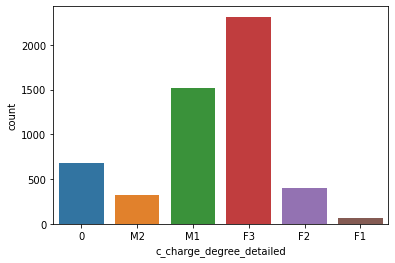

In [1712]:
sns.countplot(x="c_charge_degree_detailed", data=df_clean, order=["0","M2", "M1", "F3", "F2", "F1"])

- More than 50% of charges in our dataset were labeled as M1 or F3 
- 684 cases are encoded as 0 (arrest case no charge)

In [1713]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df_clean[df_clean.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [1714]:
index_nan_cases = df_clean[df_clean.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges. 
- These 5 cases need to be imputed
- This requires the encoding of all categorical features first

# Data preprocessing

## Select relevant features and perform train_test_split

### Create Dataframe without `race`

In [1715]:
#Select features for Classification model of general recidivism
# Select age or age_cat, exclude/ include race
columns_clas = ["age", "age_cat", "sex", #"race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas = df_clean[columns_clas].copy()

X = df_clas.drop(columns="two_year_recid")
y = df_clas["two_year_recid"]

In [1716]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

### Create Dataframe with `race`

In [1717]:
columns_clas_race = ["age", "age_cat", "sex", "race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas_race = df_clean[columns_clas_race].copy()

X_race = df_clas_race.drop(columns="two_year_recid")
y_race = df_clas_race["two_year_recid"]

In [1718]:
X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(X_race,y_race, test_size=0.3)

## Create preprocessing pipeline

- `preproc_numerical` to impute and scale features
- `preproc_ordinal` to ordinaly encode `
- `preproc_nominal` to one hot encode the other ones (only relevant when race would be a feature)

### Preprocessing pipeline without `race`as feature

In [1719]:
feat_ordinal_dict = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    #"sex": ["Male","Female"],
    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"]
    }

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal = make_pipeline(
    encoder_ordinal,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['Less than 25', '25 - 45',
                                             'Greater than 45'],
                                            ['M', 'F'],
                                            ['0', 'M2', 'M1', 'F3', 'F2',
                                             'F1']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('knnimputer', KNNImputer(missing_values=-1, n_neighbors=25)),
                ('minmaxscaler', MinMaxScaler())])

In [1720]:
# Define numerical feature once-for-all
#from sklearn.compose import make_column_selector
#feat_numerical = make_column_selector(dtype_include='number')

feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
#feat_numerical = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)


preproc_numerical = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

In [1721]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X_train.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [1722]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal), 
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2'...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['sex'])])

In [1723]:
#Test preproc pipeline
preproc.fit(X_train)

column_nam = feat_numerical + feat_ordinal +list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

test = pd.DataFrame(preproc.transform(X_train), columns=column_nam)

test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex_Male
0,0.207792,0.0,0.0,0.0,0.324324,0.5,1.0,0.6,0.0
1,0.142857,0.0,0.0,0.0,0.027027,0.5,0.0,0.4,1.0
2,0.194805,0.0,0.0,0.0,0.135135,0.5,1.0,0.6,1.0


In [1724]:
# #Test knnImputing of missing values 

# test.loc[index_nan_cases]
# test["c_charge_degree_detailed"]= test.c_charge_degree_detailed.apply(np.ceil)
# test.loc[index_nan_cases]

### Preprocessing pipeline with `race`as feature

If race is included as a feature we have to create an additional columntransformer to OHE the `race`feature. 

In [1725]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
# only relevant if race is a feature 
feat_nominal_r = sorted(list(set(X_race.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal_r = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [1726]:
preproc_race = make_column_transformer(
    (preproc_numerical, feat_numerical), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal_r, feat_nominal_r), 
    remainder="drop")

preproc_race

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2'...
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['race', 'sex'])])

In [1727]:
#Test preproc race pipeline
preproc_race.fit(X_race)

column_nam_r = feat_numerical + feat_ordinal+list(preproc_race.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_r))

test = pd.DataFrame(preproc_race.transform(X_race), columns=column_nam_r)
test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,0.649351,0.0,0.0,0.000000,0.000000,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.194805,0.0,0.0,0.000000,0.000000,0.5,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.064935,0.0,0.0,0.111111,0.108108,0.0,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Balancing

- As we already saw in the data exploration, the number of data points of the COMPAS dataset representing `two_years_recid`, `race`, `sex` is imbalanced
- This may pose a problem since ML algorithms learn by example and could therefore tend to predict under represented classes poorly

In [1728]:
#Check balancing of y 
df_clean.two_year_recid.value_counts(normalize=True)

0    0.63405
1    0.36595
Name: two_year_recid, dtype: float64

In [1729]:
#Check balancing of race
df_clean.race.value_counts(normalize=True)

African-American    0.505656
Caucasian           0.344834
Hispanic            0.084465
Other               0.058258
Asian               0.005090
Native American     0.001697
Name: race, dtype: float64

In [1730]:
#Check balancing of sex
df_clean.sex.value_counts(normalize=True)

Male      0.808258
Female    0.191742
Name: sex, dtype: float64

### SMOTE

In [1731]:
print("Number of unique cases in dataset:",df_clean.shape[0])

Number of unique cases in dataset: 5304


- Since our original dataset is relatively small, we decided against sampling down the majority class (Undersampling)
- We will therefore oversample the minority classes using the SMOTE algorithm. 
- SMOTE is an oversampling algorithm that generates new minority instances from existing minority instances based on linear combinations of existing points.
- We only use balancing techniques on the training set. We want to keep our test set as representative of real life as possible.

#### Test imblearn (outside of pipeline)

Check [imbalanced-learn](https://imbalanced-learn.org/)

In [1732]:
test_df = pd.concat([X_train, y_train], axis=1)
test_df

,age,age_cat,sex,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid
1672,35,25 - 45,Female,0,0,0,12,F,F3,1
330,30,25 - 45,Male,0,0,0,1,M,M1,0
3555,34,25 - 45,Male,0,0,0,5,F,F3,0
3036,33,25 - 45,Male,0,0,0,5,F,F3,0
2465,31,25 - 45,Male,5,0,0,10,F,0,1
...,...,...,...,...,...,...,...,...,...,...
3092,28,25 - 45,Male,0,0,0,2,F,0,0
3772,34,25 - 45,Male,0,0,0,5,F,F3,1
5191,24,Less than 25,Male,0,0,0,4,F,F2,1
5226,28,25 - 45,Female,0,0,0,5,F,F3,0


In [1733]:
test_df_trans = test_df.copy()

test_df_trans[column_nam] =preproc.transform(test_df.drop(columns="two_year_recid"))
test_df_trans = test_df_trans.drop(columns="sex")  #drop old nominal features (before OHE)

test_df_trans.head(5)

,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid,sex_Male
1672,0.207792,0.5,0.000,0.0,0.0,0.324324,1.0,0.6,1,0.0
330,0.142857,0.5,0.000,0.0,0.0,0.027027,0.0,0.4,0,1.0
3555,0.194805,0.5,0.000,0.0,0.0,0.135135,1.0,0.6,0,1.0
3036,0.181818,0.5,0.000,0.0,0.0,0.135135,1.0,0.6,0,1.0
2465,0.155844,0.5,0.625,0.0,0.0,0.270270,1.0,0.0,1,1.0


In [1734]:
X_t = test_df_trans.drop(columns=["two_year_recid"])
y_t = test_df_trans.two_year_recid

In [1735]:
X_t.columns

Index(['age', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'c_charge_degree_detailed',
       'sex_Male'],
      dtype='object')

In [1736]:
sm = SMOTENC(categorical_features=[1,6,7,8]) # index of categorical features
smt = SMOTETomek(smote=sm)

In [1737]:
X_res_t, y_res_t = smt.fit_resample(X_t, y_t)
print(f'Resampled dataset samples per class {Counter(y_res_t)}')

Resampled dataset samples per class Counter({1: 2246, 0: 2246})


In [1738]:
# Open question: How do we balance different feature/ target combinations (african_american + recid, caucasian + recid ....)

#### Test imblearn (outside of pipeline) for race

In [1739]:
test_df_r = pd.concat([X_train_race, y_train_race], axis=1)
test_df_r.head()

,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid
1672,35,25 - 45,Female,African-American,0,0,0,12,F,F3,1
330,30,25 - 45,Male,African-American,0,0,0,1,M,M1,0
3555,34,25 - 45,Male,Caucasian,0,0,0,5,F,F3,0
3036,33,25 - 45,Male,African-American,0,0,0,5,F,F3,0
2465,31,25 - 45,Male,African-American,5,0,0,10,F,0,1


In [1740]:
test_df_trans_r = test_df_r.copy()

test_df_trans_r[column_nam_r] =preproc_race.transform(test_df_r.drop(columns="two_year_recid"))
test_df_trans_r = test_df_trans_r.drop(columns=["sex", "race"]) #drop old nominal features (before OHE)

test_df_trans_r.head(5)

,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
1672,0.207792,0.5,0.0,0.0,0.0,0.324324,1.0,0.6,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
330,0.142857,0.5,0.0,0.0,0.0,0.027027,0.0,0.4,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3555,0.194805,0.5,0.0,0.0,0.0,0.135135,1.0,0.6,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3036,0.181818,0.5,0.0,0.0,0.0,0.135135,1.0,0.6,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2465,0.155844,0.5,0.5,0.0,0.0,0.270270,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Instantiate SMOTE for balancing into pipeline without `race`

Since the imblearn make_pipeline function is not 100% compatible with the sklearn make_pipeline function we can only chain the balancing step and the final predictor to our preproc pipeline in one step. Therefore we will create the final pipelines during model iteration

In [1741]:
column_nam

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'age_cat',
 'c_charge_degree',
 'c_charge_degree_detailed',
 'sex_Male']

In [1742]:
sm = SMOTENC(categorical_features=range(5,9)) # index of categorical features (for order see column_nam)
smt = SMOTETomek(smote=sm)

### Instantiate SMOTE for balancing into pipeline with `race`

In [1743]:
column_nam_r

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'age_cat',
 'c_charge_degree',
 'c_charge_degree_detailed',
 'race_African-American',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Native American',
 'race_Other',
 'sex_Male']

In [1744]:
sm_race = SMOTENC(categorical_features=range(5,15)) # index of categorical features (for order see column_nam_r)
smt_race = SMOTETomek(smote=sm_race)

# Feature selection

- Some of the columns are different representations of the same data (eg. age and age_cat) and are therfore highly correlated
- Furthermore we want to remove features that, when in combination with all the others, do not really help predict our target

## Feature correlation

Use Pearson's correlation combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others and remove one of two features.
- High correlation = redundant information

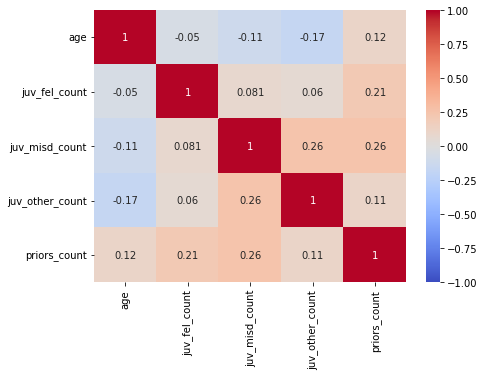

In [1745]:
corr_num = X_train.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1, annot=True);

In [1746]:
corr_df = corr_num.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
13,juv_misd_count,juv_other_count,0.257501
17,juv_other_count,juv_misd_count,0.257501
22,priors_count,juv_misd_count,0.257007
14,juv_misd_count,priors_count,0.257007
9,juv_fel_count,priors_count,0.212775


---

For **ordinal features**, we can use Spearman's rank correlation instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others.

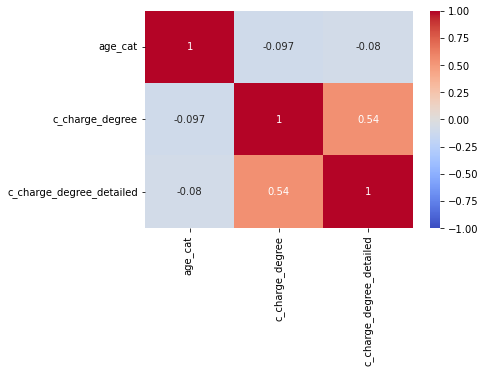

In [1747]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]), columns=feat_ordinal)
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1, annot=True);

- Using Spearman we see a high correlation between `c_charge_degree` and `c_charge_degree_detailed`
- This makes sense, since the `c_charge_degree_detailed` is our engineered feature which is a more granular classification of felonies and misdemeanors. We should therefore drop one of the features
- However, using Spearman only for the ordinally encoded features we can not assess the correlation between `age` and `age_cat` and any possible correlation between `sex` and the other features. This correlation assessment could only been performed after encoding.

---
- In order to assess the correlation between all features we use the transformed and encoded features. 
- We see the high correlation between `age_cat` and `age` and `c_charge_degree` and `c_charge_degree_detailed`

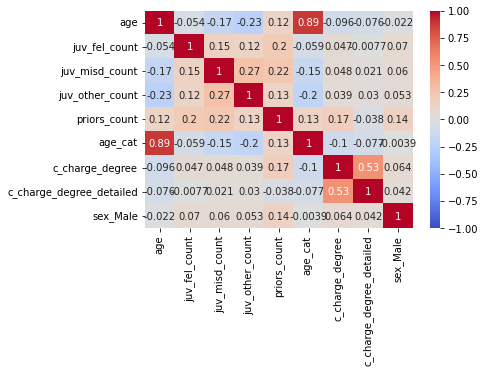

In [1748]:
df_enc = pd.DataFrame(preproc.fit_transform(X_train), columns=column_nam)
sns.heatmap(df_enc.corr(method="spearman"), cmap='coolwarm',vmin=-1, vmax=1, annot=True);

### Assess correlation on complete dataset (including `race` and `y`)

- Identify correlation between all features (including race) and the target 

In [1749]:
# Define numerical feature once-for-all for race pipeline
feat_numerical_y = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)

In [1750]:
#Create preproc pipeline with race and target y
preproc_ra_y = make_column_transformer(
    (preproc_numerical, feat_numerical_y), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal_r, feat_nominal_r), 
    remainder="drop")

preproc_ra_y

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count',
                                  'two_year_recid']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['...
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['race', 'sex'])])

In [1751]:
#Test preproc_ra_y pipeline
preproc_ra_y.fit(df_clean)

column_nam_ra_y = feat_numerical_y + feat_ordinal+ list(preproc_ra_y.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_r))

df_enc_race = pd.DataFrame(preproc_ra_y.transform(df_clean), columns=column_nam_ra_y)

df_enc_race.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,age_cat,c_charge_degree,c_charge_degree_detailed,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,0.649351,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.194805,0.0,0.0,0.000000,0.000000,1.0,0.5,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.064935,0.0,0.0,0.111111,0.108108,1.0,0.0,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0


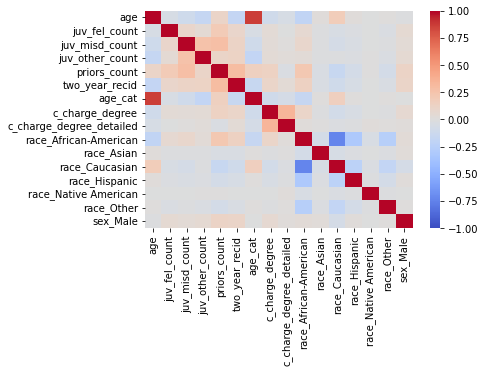

In [1752]:
sns.heatmap(df_enc_race.corr(), cmap='coolwarm',vmin=-1, vmax=1);

## Feature permutation (MDA)

We want to remove features that, when in combination with all the others, do not really help predict our target.

To do so, we use feature `permutation_importance` importance in combination with an estimator! It trains one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

In [1753]:
## Create df instead of plot 

# permutation_score = permutation_importance(pipe_forest, X_train, y_train, n_repeats=10) # Perform Permutation

# importance_df = pd.DataFrame(np.vstack((X_train.columns,
#                                         permutation_score.importances_mean)).T) # Unstack results
# importance_df.columns=['feature','score decrease']

# importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

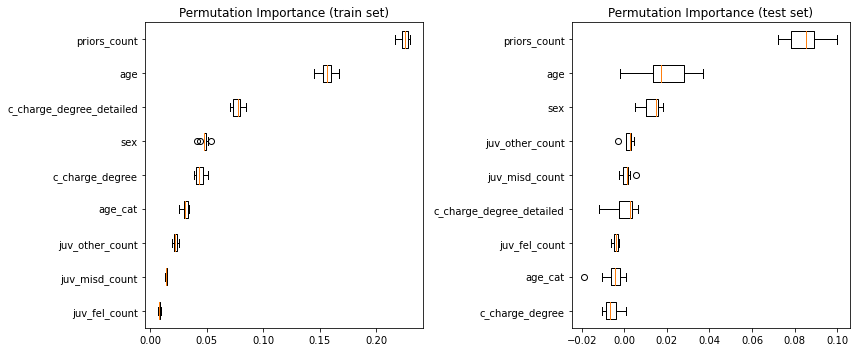

In [1754]:
pipe_forest = imblearn_make_pipeline(preproc, smt, RandomForestClassifier())
pipe_forest.fit(X_train, y_train)
permutation_score = permutation_importance(pipe_forest, X_train, y_train, n_repeats=10) # Perform Permutation

fig = plt.figure(figsize=(12, 5))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score.importances_mean.argsort()
plt.boxplot(
    permutation_score.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (train set)")

#Plot MDA test set
plt.subplot(1, 2, 2)
permutation_score_test = permutation_importance(pipe_forest, X_test, y_test, n_repeats=10)
sorted_idx = permutation_score_test.importances_mean.argsort()
plt.boxplot(
    permutation_score_test.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_test.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")

fig.tight_layout()
plt.show()

In [1755]:
# Probably only keep train ?

- Using feature permutation, we see that the shuffling the feature `age` (which was also selected by the forward and backward feature selection) significantly leads to a decrease in score
- However, the feature with the highest score decrease `priors count` didn't get selected by the other feature selection techniques, whereas `juv_fel_count`and `juv_misd_count` which got selected do not lead to any score decrease!
- This behavior may be caused by the correlation between the features (e.g. `age` and `age_cat`, `juv_fel_count`, `juv_misd_count` and `priors_count` ...):<br> When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.
- We could decide to only keep the first five features, since we already know that `c_charge_degree_detailed` and `c_charge_degree` are highly correlated

### Compare MDA on different subsets of df

- As we have seen in the correlation matrix, age_cat and age as well as c_charge_degree and c_charge_degree_detailed are highly correlated. We will now assess two subsets of the data:
- Df **without** `c_charge_degree` and `age_cat`
- DF **without** `c_charge_degree_detailed` and `age`
- Df **without** `c_charge_degree` and `age_cat` but with `race`

#### Dataframe without `c_charge_degree` and `age_cat`

In [1756]:
# Create new pipeline without features age_cat and c_charge_degree
feat_ordinal_dict_s = {
#    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
#    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
#    "sex": ["Male","Female"]
    }

feat_ordinal_s = sorted(feat_ordinal_dict_s.keys()) # sort alphabetically
feat_ordinal_values_sorted_s = [feat_ordinal_dict_s[i] for i in feat_ordinal_s]

encoder_ordinal_s = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s = make_pipeline(
    encoder_ordinal_s,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s;

In [1757]:
preproc_s = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
    (preproc_nominal, feat_nominal),
    remainder="drop")

pipe_forest_s = make_pipeline(preproc_s, RandomForestClassifier())
pipe_forest_s.fit(X_train, y_train);

In [1758]:
column_nam_sub = feat_numerical + feat_ordinal_s +list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

X_train_sub_trans = pd.DataFrame(preproc_s.transform(X_train), columns=column_nam_sub)

In [1759]:
permutation_score_s1 = permutation_importance(pipe_forest_s, X_train[feat_numerical + feat_ordinal_s+feat_nominal], y_train, n_repeats=10) # Perform Permutation

In [1760]:
X_train_sub_trans.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
0,0.207792,0.0,0.0,0.0,0.324324,0.6,0.0
1,0.142857,0.0,0.0,0.0,0.027027,0.4,1.0
2,0.194805,0.0,0.0,0.0,0.135135,0.6,1.0


---

#### Dataframe without `c_charge_degree_detailed` and `age`

In [1761]:
# Create new pipeline without features c_charge_degree_detailed and age
feat_ordinal_dict_s2 = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
#    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
#    "sex": ["Male","Female"]
    }

feat_ordinal_s2 = sorted(feat_ordinal_dict_s2.keys()) # sort alphabetically
feat_ordinal_values_sorted_s2 = [feat_ordinal_dict_s2[i] for i in feat_ordinal_s2]

encoder_ordinal_s2 = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s2,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s2 = make_pipeline(
    encoder_ordinal_s2,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s2;

In [1762]:
# Define numerical feature once-for-all
feat_numerical_s2 = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
feat_numerical_s2.remove("age") #Remove age from list of numerical features

preproc_numerical_s2 = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

In [1763]:
preproc_s2 = make_column_transformer(
    (preproc_numerical_s2, feat_numerical_s2),
    (preproc_ordinal_s2, feat_ordinal_s2),
    (preproc_nominal, feat_nominal),
    remainder="drop")

pipe_forest_s2 = make_pipeline(preproc_s2, RandomForestClassifier())
pipe_forest_s2.fit(X_train, y_train);

In [1764]:
permutation_score_s2 = permutation_importance(pipe_forest_s2, X_train[feat_numerical_s2 + feat_ordinal_s2 +feat_nominal], y_train, n_repeats=10) # Perform Permutation

---
**Show both MDA plots side by side**

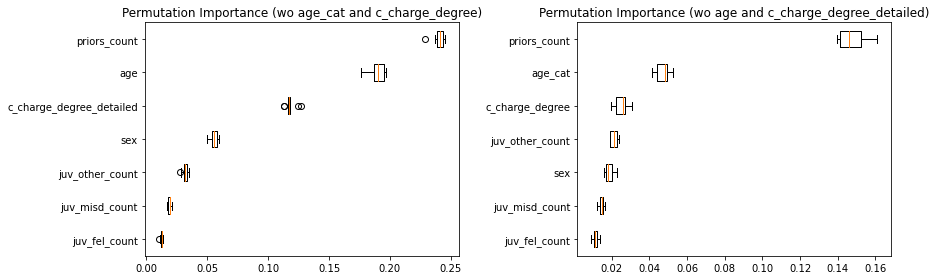

In [1765]:
# Both plots side by side
fig = plt.figure(figsize=(13,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_s2.importances_mean.argsort()
plt.boxplot(
    permutation_score_s2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical_s2 + feat_ordinal_s2 +feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed)")

fig.tight_layout()
plt.show();

- We see more important features in the subset with `age` and `c_charge_degree_detailed`
- Removing `age_cat` and `c_charge_degree` also led to an increase of the overall importance for the other features
- We will now check if including `race` as a feature to the subset might even increase the permutation scores

#### Dataframe without `c_charge_degree` and `age_cat`, but with `race`

In [1766]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
# only relevant if race is a feature 
feat_nominal_rs = sorted(list(set(X_race.columns.drop(["age_cat", "c_charge_degree"])) - set(feat_numerical) - set(feat_ordinal_s)))

preproc_nominal_rs = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [1767]:
preproc_rs = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
    (preproc_nominal_rs, feat_nominal_rs),
    remainder="drop")

pipe_forest_rs = imblearn_make_pipeline(preproc_rs, RandomForestClassifier())
pipe_forest_rs.fit(X_train_race, y_train_race)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               'M2',
                                                                                               'M1',
                                                                                               'F3',
                                                                                               'F2',
                                                                                               'F1']],
                                                                                  d...
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['c_charge_degree_detailed']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['race', 'sex'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [1768]:
column_nam_rsub = feat_numerical + feat_ordinal_s +list(preproc_rs.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_rs))

X_train_rsub_trans = pd.DataFrame(preproc_rs.transform(X_train_race), columns=column_nam_rsub)
X_train_rsub_trans.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,0.207792,0.0,0.0,0.0,0.324324,0.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142857,0.0,0.0,0.0,0.027027,0.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.194805,0.0,0.0,0.0,0.135135,0.6,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [1769]:
permutation_score_rs = permutation_importance(pipe_forest_rs, X_train_race[feat_numerical + feat_ordinal_s+feat_nominal_rs], y_train_race, n_repeats=10) # Perform Permutation

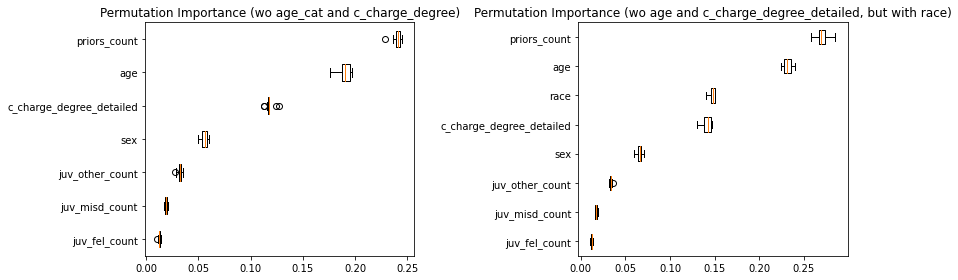

In [1770]:
# Both plots side by side
fig = plt.figure(figsize=(13,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_rs.importances_mean.argsort()
plt.boxplot(
    permutation_score_rs.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s +feat_nominal_rs)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed, but with race)")

fig.tight_layout()
plt.show();

In [1771]:
# with race we see a further overall increase in MDA 
# we will thus also use this pipeline in further modelinga

## Impurity reduction (MDI)

In [1772]:
# Instantiate Random Forest Classifier for MDI 
clf_forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, clf_forest)
pipe_forest.fit(X_train, y_train);

In [1773]:
# Create new balancer for subset pipeline
sm_s = SMOTENC(categorical_features=[5,6]) # index of categorical features (for order see column_nam_sub)
smt_s = SMOTETomek(smote=sm_s)

# Instantiate Random Forest Classifier on Subset for MDI 
clf_forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, clf_forest)
pipe_forest_s.fit(X_train, y_train);

In [1774]:
# Create new balancer for subset pipeline with race
sm_rs = SMOTENC(categorical_features=np.arange(5,13)) # index of categorical features (for order see column_nam_rsub)
smt_rs = SMOTETomek(smote=sm_rs)

# Instantiate Random Forest Classifier on Subset for MDI 
clf_forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_rs, clf_forest)
pipe_forest_rs.fit(X_train_race, y_train_race);

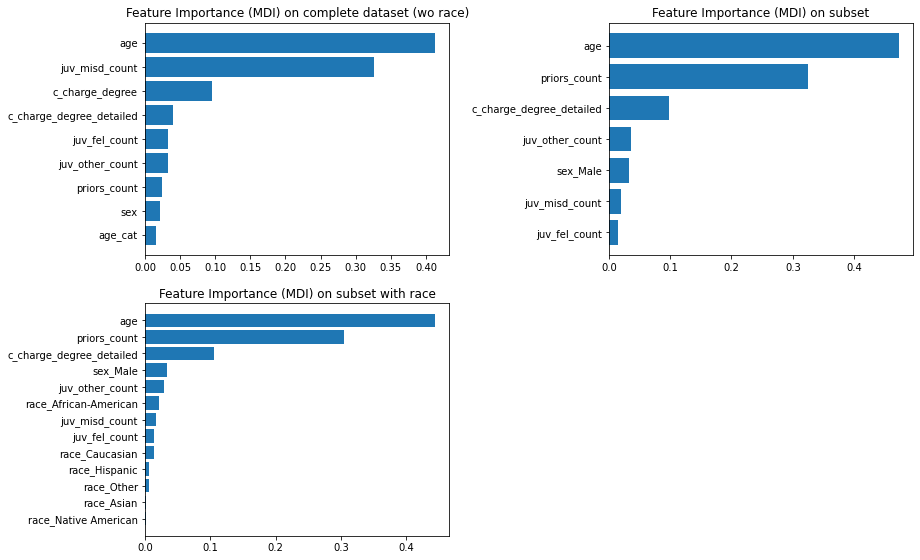

In [1775]:
# Both plots side by side
fig = plt.figure(figsize=(13,8))

#Plot MDA train set
plt.subplot(2, 2, 1)
feature_importance = pipe_forest.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on complete dataset (wo race)");

plt.subplot(2, 2, 2)
feature_importance_s = pipe_forest_s.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_s)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance_s[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_sub_trans.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on subset");

plt.subplot(2, 2, 3)
feature_importance_rs = pipe_forest_rs.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_rs)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance_rs[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_rsub_trans.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on subset with race");


plt.tight_layout(pad=1.5)

Some text

## Forward Selection using `SequentialFeatureSelector` 

In [1776]:
sfs_models = [LogisticRegression(solver='liblinear', penalty='l1'), LogisticRegression(), DecisionTreeClassifier()]
sfs_results = []

In [1777]:
# for model in sfs_models:
#     sfs_forward = SequentialFeatureSelector(model, direction="forward", cv=None)
#     pipe_sfs = imblearn_make_pipeline(preproc, smt, sfs_forward, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,9)}

#     grid_sfs = GridSearchCV(pipe_sfs, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs.best_params_)
#     print(grid_sfs.best_score_)
    
#     sfs_results.append(grid_sfs)

In [1778]:
# joblib.dump(sfs_results[0], 'stored_models/grid_sfs_log_l1.pkl')
# joblib.dump(sfs_results[1], 'stored_models/grid_sfs_log.pkl')
# joblib.dump(sfs_results[2], 'stored_models/grid_sfs_tree.pkl')

In [1779]:
sfs_results.append(joblib.load('stored_models/grid_sfs_log_l1.pkl'))
sfs_results.append(joblib.load('stored_models/grid_sfs_log.pkl'))
sfs_results.append(joblib.load('stored_models/grid_sfs_tree.pkl'))

Trying to unpickle estimator SimpleImputer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OrdinalEncoder from version 1.0.1 when using version 1.0.2. This might lead to breaking code or

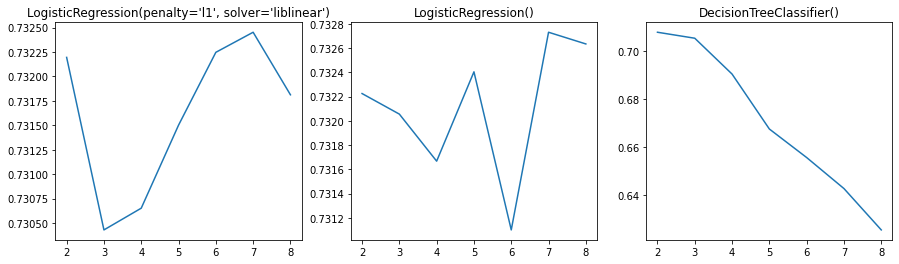

In [1780]:
fig,ax = plt.subplots(1,3, figsize=(15,4))
# Check results of gridSearch 
sns.lineplot(x=np.arange(2,9), y=sfs_results[0].cv_results_["mean_test_roc_auc"], ax=ax[0])
ax[0].set_title(str(sfs_models[0]))
sns.lineplot(x=np.arange(2,9), y=sfs_results[1].cv_results_["mean_test_roc_auc"], ax=ax[1])
ax[1].set_title(str(sfs_models[1]))
sns.lineplot(x=np.arange(2,9), y=sfs_results[2].cv_results_["mean_test_roc_auc"], ax=ax[2])
ax[2].set_title(str(sfs_models[2]));

In [1781]:
# Print selected features for each model
for i, results in enumerate(sfs_results):
    # Get selected features
    sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

    print(sfs_models[i])
    print(f"Selected columns: {X.columns[sfs_sel_feat]}")
    print()

LogisticRegression(penalty='l1', solver='liblinear')
Selected columns: Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'priors_count', 'c_charge_degree'],
      dtype='object')

LogisticRegression()
Selected columns: Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'c_charge_degree', 'c_charge_degree_detailed'],
      dtype='object')

DecisionTreeClassifier()
Selected columns: Index(['juv_misd_count', 'juv_other_count'], dtype='object')



Out of the 9 total features the Logisitic Regression models with l1 and l2 penalty 7 were selected, for the DecisionTree only 3 were selected

#### Test Forward feature selection on subset 

In [1782]:
# sfs_back_models_s = [LogisticRegression(solver='liblinear', penalty='l1'), LogisticRegression(), DecisionTreeClassifier()]
# sfs_back_resaults_s = []

In [1783]:
# for model in sfs_back_models_s:
#     sfs__b = SequentialFeatureSelector(model, direction="forward", cv=None)
#     pipe_sfs_bs = make_pipeline(preproc_s, sfs__b, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,7)}

#     grid_sfs_bs = GridSearchCV(pipe_sfs_bs, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs_bs.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs_bs.best_params_)
#     print(grid_sfs_bs.best_score_)
    
#     sfs_back_results_s.append(grid_sfs_bs)

In [1784]:
# fig,ax = plt.subplots(1,3, figsize=(15,4))
# # Check results of gridSearch 
# for i, result in enumerate(sfs_back_results_s):
#     sns.lineplot(x=np.arange(2,7), y=result.cv_results_["mean_test_roc_auc"], ax=ax[i])
#     ax[i].set_title(str(sfs_back_models_s[i]))

In [1785]:
# # Print selected features for each model
# for i, results in enumerate(sfs_back_results_s):
#     # Get selected features
#     sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

#     print(sfs_back_models_s[i])
#     print(f"Selected columns: {X_train_sub_trans.columns[sfs_sel_feat]}")
#     print()

In [1786]:
# test with other estimator at end

In [1787]:
# sfs_back_models_s2= [DecisionTreeClassifier(), RandomForestClassifier()]
# sfs_back_results_s2 = []

# for model in sfs_back_models_s2:
#     sfs_b2 = SequentialFeatureSelector(LogisticRegression(penalty='l1', solver='liblinear'), direction="forward", cv=None)
#     pipe_sfs_bs2 = make_pipeline(preproc_s, sfs_b2, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,7)}

#     grid_sfs_bs2 = GridSearchCV(pipe_sfs_bs2, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs_bs2.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs_bs2.best_params_)
#     print(grid_sfs_bs2.best_score_)
    
#     sfs_back_results_s2.append(grid_sfs_bs2)

In [1788]:
# fig,ax = plt.subplots(1,2, figsize=(15,4))
# # Check results of gridSearch 
# for i, result in enumerate(sfs_back_results_s2):
#     sns.lineplot(x=np.arange(2,7), y=result.cv_results_["mean_test_roc_auc"], ax=ax[i])
#     ax[i].set_title(str(sfs_back_models_s2[i]))

In [1789]:
# # Print selected features for each model
# for i, results in enumerate(sfs_back_results_s2):
#     # Get selected features
#     sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

#     print(sfs_back_models_s2[i])
#     print(f"Selected columns: {X_train_sub_trans.columns[sfs_sel_feat]}")
#     print()

In [1790]:
# sfs_back_models_s2= [DecisionTreeClassifier(), RandomForestClassifier()]
# sfs_back_results_s2 = []

# for model in sfs_back_models_s2:
#     sfs_b2 = SequentialFeatureSelector(LogisticRegression(), direction="forward", cv=None)
#     pipe_sfs_bs2 = make_pipeline(preproc_s, sfs_b2, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,7)}

#     grid_sfs_bs2 = GridSearchCV(pipe_sfs_bs2, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs_bs2.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs_bs2.best_params_)
#     print(grid_sfs_bs2.best_score_)
    
#     sfs_back_results_s2.append(grid_sfs_bs2)

In [1791]:
# fig,ax = plt.subplots(1,2, figsize=(15,4))
# # Check results of gridSearch 
# for i, result in enumerate(sfs_back_results_s2):
#     sns.lineplot(x=np.arange(2,7), y=result.cv_results_["mean_test_roc_auc"], ax=ax[i])
#     ax[i].set_title(str(sfs_back_models_s2[i]))

In [1792]:
# # Print selected features for each model
# for i, results in enumerate(sfs_back_results_s2):
#     # Get selected features
#     sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

#     print(sfs_back_models_s2[i])
#     print(f"Selected columns: {X_train_sub_trans.columns[sfs_sel_feat]}")
#     print()

In [1793]:
# sfs_back_models_s2= [LogisticRegression(penalty='l1', solver='liblinear'), RandomForestClassifier()]
# sfs_back_results_s2 = []

# for model in sfs_back_models_s2:
#     sfs_b2 = SequentialFeatureSelector(RandomForestClassifier(), direction="forward", cv=None)
#     pipe_sfs_bs2 = make_pipeline(preproc_s, sfs_b2, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,7)}

#     grid_sfs_bs2 = GridSearchCV(pipe_sfs_bs2, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs_bs2.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs_bs2.best_params_)
#     print(grid_sfs_bs2.best_score_)
    
#     sfs_back_results_s2.append(grid_sfs_bs2)

In [1794]:
# fig,ax = plt.subplots(1,2, figsize=(15,4))
# # Check results of gridSearch 
# for i, result in enumerate(sfs_back_results_s2):
#     sns.lineplot(x=np.arange(2,7), y=result.cv_results_["mean_test_roc_auc"], ax=ax[i])
#     ax[i].set_title(str(sfs_back_models_s2[i]))

In [1795]:
# # Print selected features for each model
# for i, results in enumerate(sfs_back_results_s2):
#     # Get selected features
#     sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

#     print(sfs_back_models_s2[i])
#     print(f"Selected columns: {X_train_sub_trans.columns[sfs_sel_feat]}")
#     print()

## Backward Selection using `SequentialFeatureSelector` 

In [1796]:
# sfs_back_models = [LogisticRegression(solver='liblinear', penalty='l1'), LogisticRegression(), DecisionTreeClassifier()]
# sfs_back_results = []

In [1797]:
# for model in sfs_back_models:
#     sfs__b = SequentialFeatureSelector(model, direction="backward", cv=None)
#     pipe_sfs_b = imblearn_make_pipeline(preproc, smt, sfs__b, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,9)}

#     grid_sfs_b = GridSearchCV(pipe_sfs_b, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs_b.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs_b.best_params_)
#     print(grid_sfs_b.best_score_)
    
#     sfs_back_results.append(grid_sfs_b)

In [1798]:
# fig,ax = plt.subplots(1,3, figsize=(15,4))
# # Check results of gridSearch 
# sns.lineplot(x=np.arange(2,9), y=sfs_back_results[0].cv_results_["mean_test_roc_auc"], ax=ax[0])
# ax[0].set_title(str(sfs_back_models[0]))
# sns.lineplot(x=np.arange(2,9), y=sfs_back_results[1].cv_results_["mean_test_roc_auc"], ax=ax[1])
# ax[1].set_title(str(sfs_back_models[1]))
# sns.lineplot(x=np.arange(2,9), y=sfs_back_results[2].cv_results_["mean_test_roc_auc"], ax=ax[2])
# ax[2].set_title(str(sfs_back_models[2]));

In [1799]:
# # Print selected features for each model
# for i, results in enumerate(sfs_back_results):
#     # Get selected features
#     sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

#     print(sfs_back_models[i])
#     print(f"Selected columns: {X.columns[sfs_sel_feat]}")
#     print()

Using backward selection we get a quiet different result. From the 9 possible features X were selected

# Model iteration

## Baseline model

As a baseline model for the prediction of general recidivism we choose a "Dummy" Classifier which will predict themost frequent class in the target (no_recid)

In [1800]:
model_name = "Dummy baseline"
dummy_clf = DummyClassifier(strategy="most_frequent") #Instantiate Dummy Classifier 
baseline = imblearn_make_pipeline(preproc, smt, dummy_clf) #Create pipeline

In [1801]:
cv_baseline = cross_validate(baseline, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

In [1802]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_baseline)

In [1803]:
#import warnings
#warnings.filterwarnings('ignore')

In [1804]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_baseline['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_baseline['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Dummy baseline: 0.63
10 fold cv ROC AUC score of Dummy baseline: 0.5


`DummyClassifier` has no predict function and thus the precision, recall and f1 metric is set to 0 

## Logistic Regression

### Untuned Logistic Regression

#### Complete Dataset

In [1805]:
model_name = "Vanilla Logistic Regression"
logreg = LogisticRegression()
pipe_log = imblearn_make_pipeline(preproc, smt, logreg) ##Create pipeline

In [1806]:
cv_logreg = cross_validate(pipe_log, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1807]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg)

In [1808]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla Logistic Regression: 0.68
10 fold cv ROC AUC score of Vanilla Logistic Regression: 0.73


In [1809]:
pipe_log.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_log

#### Subset

In [1810]:
model_name = "Vanilla Logistic Regression_Sub"
logreg = LogisticRegression()
pipe_log_s = imblearn_make_pipeline(preproc_s, smt_s, logreg) ##Create pipeline

In [1811]:
cv_logreg_s = cross_validate(pipe_log_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1812]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg_s)

In [1813]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla Logistic Regression_Sub: 0.68
10 fold cv ROC AUC score of Vanilla Logistic Regression_Sub: 0.74


In [1814]:
pipe_log_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_log_s

#### Subset with race 

In [1815]:
model_name = "Vanilla Logistic Regression_rSub"
logreg = LogisticRegression()
pipe_log_rs = imblearn_make_pipeline(preproc_rs, smt_rs, logreg) ##Create pipeline

In [1816]:
cv_logreg_rs = cross_validate(pipe_log_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1817]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg_rs)

In [1818]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla Logistic Regression_rSub: 0.67
10 fold cv ROC AUC score of Vanilla Logistic Regression_rSub: 0.73


In [1819]:
pipe_log_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_log_rs

### Tuned Logistic Regression

#### Complete Dataset

In [1820]:
model_name = "Tuned Logistic Regression"

The `l2` solvers are calculated separately to the `elasticnet`, because these solvers do not work with `l1`

In [1821]:
param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)},
              # Param grid for different l2 solvers
              {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

In [1822]:
grid_logreg_tuned = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1823]:
#grid_logreg_tuned.fit(X_train, y_train);

In [1824]:
# Save grid search results as .pkl file 
#joblib.dump(grid_logreg_tuned, 'stored_models/grid_logreg_tuned.pkl')

In [1825]:
# Load best model .pkl file 
grid_logreg_tuned = joblib.load('stored_models/grid_logreg_tuned.pkl')

Trying to unpickle estimator SimpleImputer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OrdinalEncoder from version 1.0.1 when using version 1.0.2. This might lead to breaking code or

In [1826]:
print(grid_logreg_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned.best_score_, 2)}")

{'logisticregression__C': 1.8888888888888888, 'logisticregression__l1_ratio': 0.9, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
10 fold cv ROC AUC score of Tuned Logistic Regression: 0.74


Some explanations

In [1827]:
# Store trained model
dict_models[model_name]=grid_logreg_tuned.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned)

#### Subset

In [1828]:
model_name = "Tuned Logistic Regression_Sub"

In [1829]:
param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)},
              # Param grid for different l2 solvers
              {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

In [1830]:
grid_logreg_tuned_s = GridSearchCV(pipe_log_s, param_grid, 
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1831]:
#grid_logreg_tuned_s.fit(X_train, y_train);

In [1832]:
# Save grid search results as .pkl file 
#joblib.dump(grid_logreg_tuned_s, 'stored_models/grid_logreg_tuned_s.pkl')

In [1833]:
# Load best model .pkl file 
grid_logreg_tuned_s = joblib.load('stored_models/grid_logreg_tuned_s.pkl')

In [1834]:
print(grid_logreg_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned_s.best_score_, 2)}")

{'logisticregression__C': 2.833333333333333, 'logisticregression__solver': 'sag'}
10 fold cv ROC AUC score of Tuned Logistic Regression_Sub: 0.74


Some explanation

In [1835]:
# Store trained model
dict_models[model_name]=grid_logreg_tuned_s.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned_s)

#### Subset with race

In [1836]:
model_name = "Tuned Logistic Regression_rSub"

In [1837]:
param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.arange(2,2.5,0.1),
               'logisticregression__l1_ratio': np.arange(0.6,0.7,0.05),
               'logisticregression__max_iter': [250],
              # Param grid for different l2 solvers
               'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

In [1838]:
grid_logreg_tuned_rs = GridSearchCV(pipe_log_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1839]:
#grid_logreg_tuned_rs.fit(X_train_race, y_train_race);

In [1840]:
# Save grid search results as .pkl file 
#joblib.dump(grid_logreg_tuned_rs, 'stored_models/grid_logreg_tuned_rs.pkl')

In [1841]:
# Load best model .pkl file 
grid_logreg_tuned_rs = joblib.load('stored_models/grid_logreg_tuned_rs.pkl')

In [1842]:
print(grid_logreg_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned_rs.best_score_, 2)}")

{'logisticregression__C': 2.4000000000000004, 'logisticregression__l1_ratio': 0.6, 'logisticregression__max_iter': 250, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
10 fold cv ROC AUC score of Tuned Logistic Regression_rSub: 0.73


In [1843]:
# Store trained model
dict_models[model_name]=grid_logreg_tuned_rs.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned_rs)

## Single tree models

Now let's look at Trees. For our project we analyzed following models:
- Vanilla Decision Trees
- Tuned Decision Tree
- Bagged Tuned Decision Tree
- Vanilla Random Forest
- Tuned Random Forest
- Tuned XGB Classifier

### Single "vanilla" tree model

#### Complete Dataset

In [1844]:
model_name = "Vanilla single Tree"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

In [1845]:
cv_tree = cross_validate(pipe_tree, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1846]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree)

In [1847]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla single Tree: 0.69
10 fold cv ROC AUC score of Vanilla single Tree: 0.71


In [1848]:
pipe_tree.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_tree

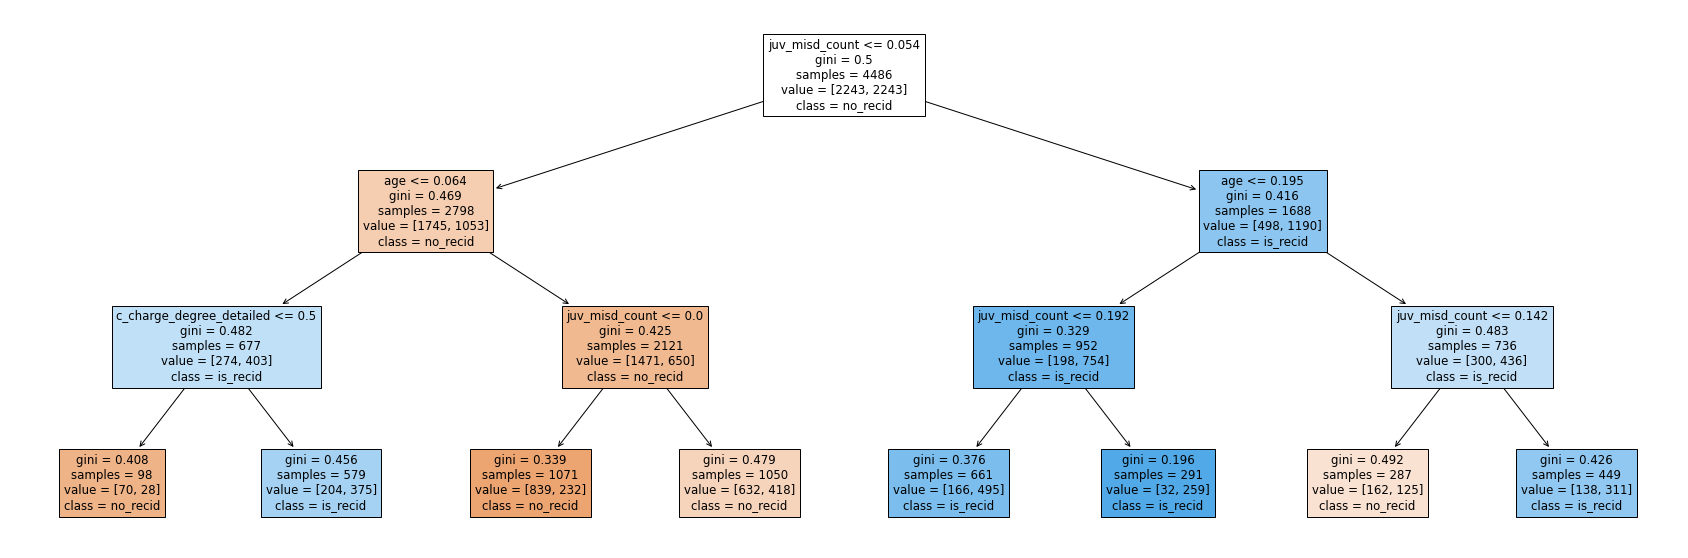

In [1849]:
plt.figure(figsize=(30,10))
plot_tree(pipe_tree["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

Some comments

#### Subset

In [1850]:
model_name = "Vanilla single Tree_Sub"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree_s = imblearn_make_pipeline(preproc_s, smt_s, tree) ##Create pipeline

In [1851]:
cv_tree_s = cross_validate(pipe_tree_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1852]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree_s)

In [1853]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla single Tree_Sub: 0.68
10 fold cv ROC AUC score of Vanilla single Tree_Sub: 0.71


In [1854]:
pipe_tree_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_tree_s

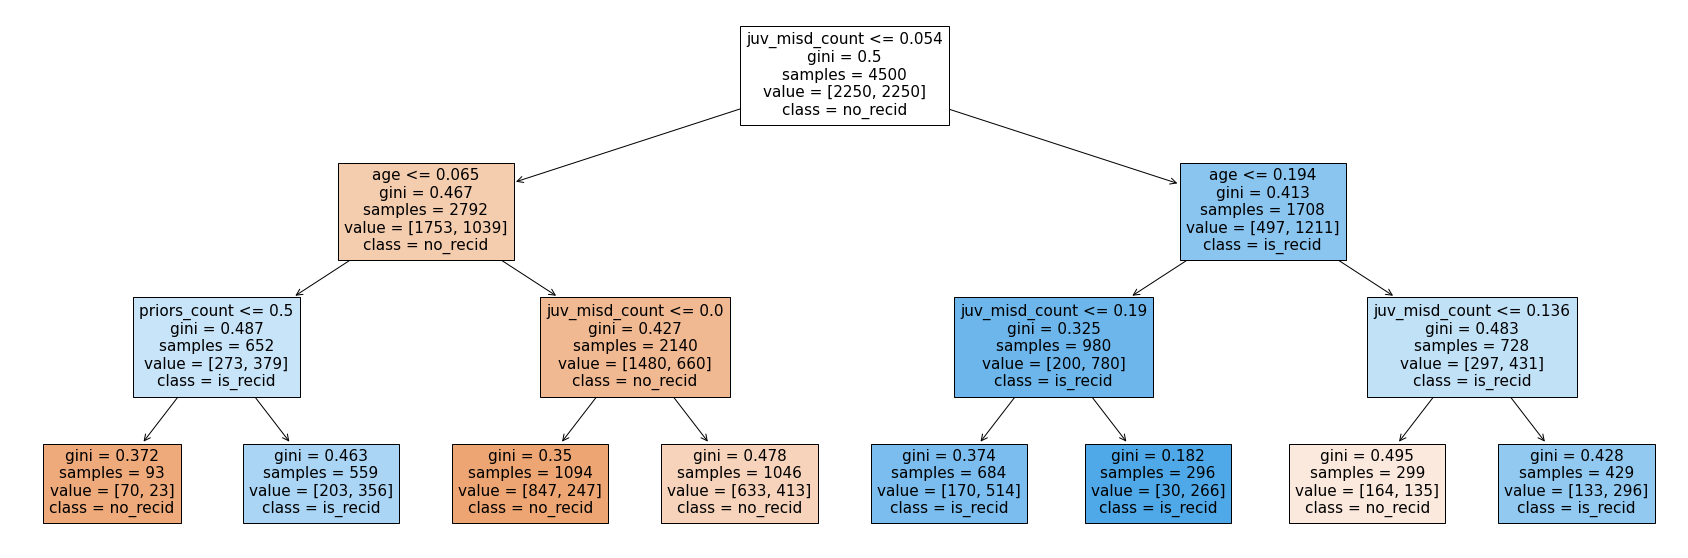

In [1855]:
plt.figure(figsize=(30,10))
plot_tree(pipe_tree_s["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

Some comment

#### Subset with race

In [1856]:
model_name = "Vanilla single Tree_rSub"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree_rs = imblearn_make_pipeline(preproc_rs, smt_s, tree) ##Create pipeline

In [1857]:
cv_tree_rs = cross_validate(pipe_tree_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1858]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree_rs)

In [1859]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla single Tree_rSub: 0.69
10 fold cv ROC AUC score of Vanilla single Tree_rSub: 0.71


In [1860]:
pipe_tree_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_tree_rs

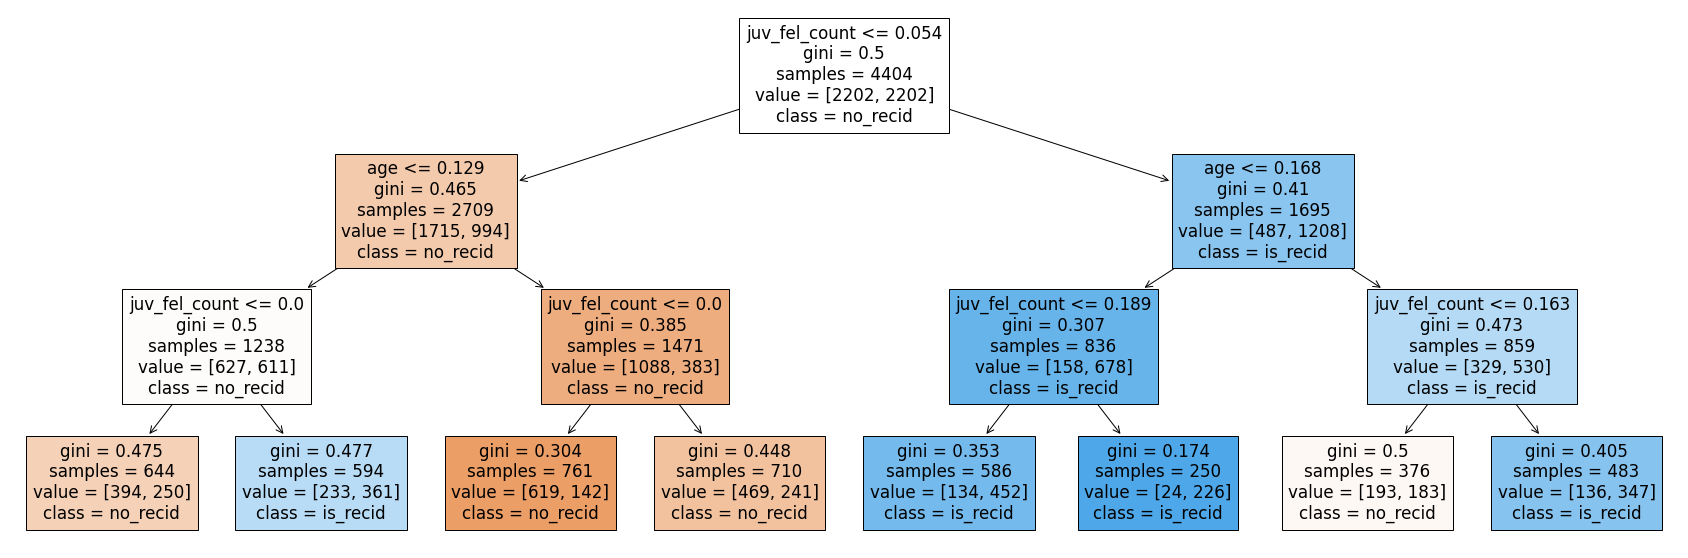

In [1861]:
plt.figure(figsize=(30,10))
plot_tree(pipe_tree_rs["decisiontreeclassifier"], 
          feature_names=X_train_race.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

### Single hyperparameter-tuned tree

#### Complete Dataset

In [1862]:
model_name = "Tuned single Tree"
tree = DecisionTreeClassifier()
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

In [1863]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

In [1864]:
grid_tree_tuned = GridSearchCV(pipe_tree, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1865]:
#grid_tree_tuned.fit(X_train, y_train);

In [1866]:
# Save grid search results as .pkl file 
#joblib.dump(grid_tree_tuned, 'stored_models/grid_tree_tuned.pkl')

In [1867]:
# Load best model .pkl file 
grid_tree_tuned = joblib.load('stored_models/grid_tree_tuned.pkl')

Trying to unpickle estimator SimpleImputer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OrdinalEncoder from version 1.0.1 when using version 1.0.2. This might lead to breaking code or

In [1868]:
print(grid_tree_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned.best_score_, 2)}")

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 81, 'decisiontreeclassifier__min_samples_split': 8}
10 fold cv ROC AUC score of Tuned single Tree: 0.71


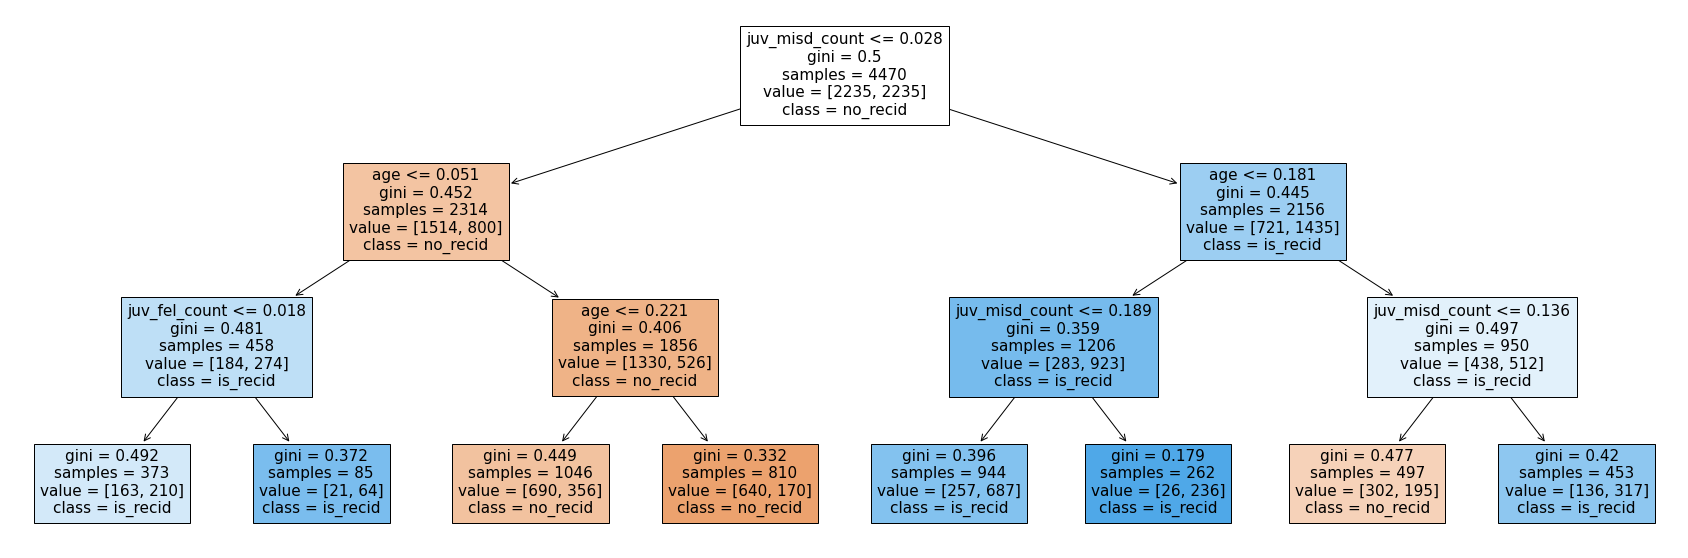

In [1869]:
plt.figure(figsize=(30,10))
plot_tree(grid_tree_tuned.best_estimator_["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

Some comments

In [1870]:
# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned)

#### Subset

In [1871]:
model_name = "Tuned single Tree_Sub"
tree = DecisionTreeClassifier()
pipe_tree_s = imblearn_make_pipeline(preproc_s, smt_s, tree) ##Create pipeline

In [1872]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

In [1873]:
grid_tree_tuned_s = GridSearchCV(pipe_tree_s, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1874]:
#grid_tree_tuned_s.fit(X_train, y_train);

In [1875]:
# Save grid search results as .pkl file 
#joblib.dump(grid_tree_tuned_s, 'stored_models/grid_tree_tuned_s.pkl')

In [1876]:
# Load best model .pkl file 
grid_tree_tuned_s = joblib.load('stored_models/grid_tree_tuned_s.pkl')

In [1877]:
print(grid_tree_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned_s.best_score_, 2)}")

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 61, 'decisiontreeclassifier__min_samples_split': 8}
10 fold cv ROC AUC score of Tuned single Tree_Sub: 0.72


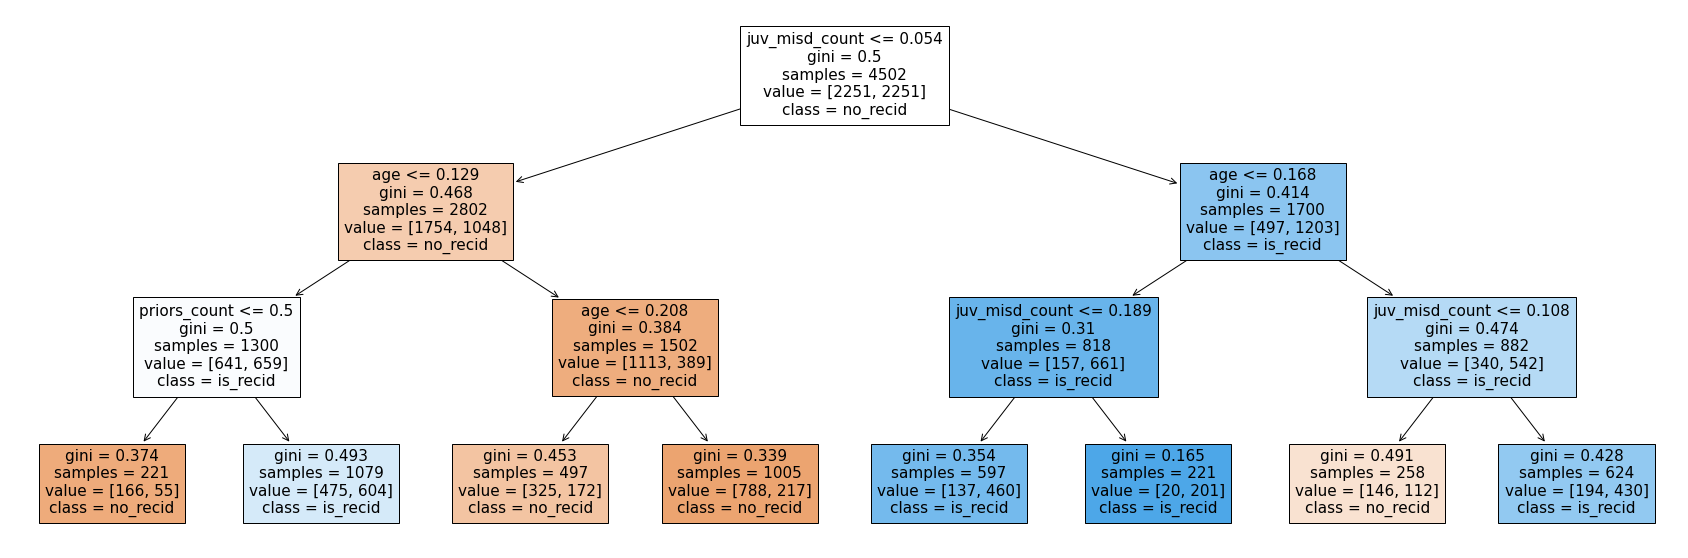

In [1878]:
plt.figure(figsize=(30,10))
plot_tree(grid_tree_tuned_s.best_estimator_["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

Some text

In [1879]:
# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned_s)

#### Subset with race

In [1880]:
model_name = "Tuned single Tree_rSub"
tree = DecisionTreeClassifier()
pipe_tree_rs = imblearn_make_pipeline(preproc_rs, smt_s, tree) ##Create pipeline

In [1881]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

In [1882]:
grid_tree_tuned_rs = GridSearchCV(pipe_tree_rs, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1883]:
#grid_tree_tuned_rs.fit(X_train_race, y_train_race);

In [1884]:
# Save grid search results as .pkl file 
#joblib.dump(grid_tree_tuned_rs, 'stored_models/grid_tree_tuned_rs.pkl')

In [1885]:
# Load best model .pkl file 
grid_tree_tuned_rs = joblib.load('stored_models/grid_tree_tuned_rs.pkl')

In [1886]:
print(grid_tree_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned_rs.best_score_, 2)}")

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 21, 'decisiontreeclassifier__min_samples_split': 6}
10 fold cv ROC AUC score of Tuned single Tree_rSub: 0.72


In [1887]:
# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned_rs)

## Bagged Tuned Decision Tree

#### Complete Dataset

In [1888]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old = grid_tree_tuned.best_params_
best_params_new = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old.items()}

In [1889]:
model_name = "Bagged tuned single Tree"
base_estimator=DecisionTreeClassifier(**best_params_new) # Instantiate best model from gridsearch
bagged_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(**best_params_new), n_estimators=501)
pipe_bagtree = imblearn_make_pipeline(preproc, smt, bagged_tree) ##Create pipeline

In [1890]:
#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [320],
               'baggingclassifier__max_samples': [0.5],
               'baggingclassifier__max_features': [0.6],
               'baggingclassifier__oob_score': [True]
               }

In [1891]:
grid_bagtree = GridSearchCV(pipe_bagtree, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1892]:
#grid_bagtree.fit(X_train, y_train);

In [1893]:
# Save grid search results as .pkl file 
#joblib.dump(grid_bagtree, 'stored_models/grid_bagtree.pkl')

In [1894]:
# Load best model .pkl file 
grid_bagtree = joblib.load('stored_models/grid_bagtree.pkl')

Trying to unpickle estimator BaggingClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [1895]:
print(grid_bagtree.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree.best_estimator_['baggingclassifier'].oob_score_,2)}")

{'baggingclassifier__max_features': 0.6, 'baggingclassifier__max_samples': 0.5, 'baggingclassifier__n_estimators': 320, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree: 0.74
ROC AUC score on OOB samples: 0.71


In [1896]:
# Store trained model and cv_results
dict_models[model_name]=grid_bagtree.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree)

In [1897]:
# Some text

#### Subset

In [1898]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old_s = grid_tree_tuned_s.best_params_
best_params_new_s = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old_s.items()}

In [1899]:
model_name = "Bagged tuned single Tree_Sub"
base_estimator_s=DecisionTreeClassifier(**best_params_new_s) # Instantiate best model from gridsearch
bagged_tree_s = BaggingClassifier(base_estimator=base_estimator_s, n_estimators=501)
pipe_bagtree_s = imblearn_make_pipeline(preproc_s, smt_s, bagged_tree_s) ##Create pipeline

In [1900]:
#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [250, 320, 370],
               'baggingclassifier__max_samples': [0.4,0.5,0.6],
               'baggingclassifier__max_features': [0.5,0.6,0.7,1],
               'baggingclassifier__oob_score': [True]
               }

In [1901]:
grid_bagtree_s = GridSearchCV(pipe_bagtree_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1902]:
#grid_bagtree_s.fit(X_train, y_train);

In [1903]:
# Save grid search results as .pkl file 
#joblib.dump(grid_bagtree_s, 'stored_models/grid_bagtree_s.pkl')

In [1904]:
# Load best model .pkl file 
grid_bagtree_s = joblib.load('stored_models/grid_bagtree_s.pkl')

In [1905]:
print(grid_bagtree_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree_s.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree_s.best_estimator_['baggingclassifier'].oob_score_,2)}")

{'baggingclassifier__max_features': 0.7, 'baggingclassifier__max_samples': 0.5, 'baggingclassifier__n_estimators': 320, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree_Sub: 0.74
ROC AUC score on OOB samples: 0.7


In [1906]:
# Store trained model and cv_results
dict_models[model_name]=grid_bagtree_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree_s)

In [1907]:
# Some text

#### Subset with race

In [1908]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old_rs = grid_tree_tuned_rs.best_params_
best_params_new_rs = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old_rs.items()}

In [1909]:
model_name = "Bagged tuned single Tree_rSub"
base_estimator_rs=DecisionTreeClassifier(**best_params_new_rs) # Instantiate best model from gridsearch
bagged_tree_rs = BaggingClassifier(base_estimator=base_estimator_rs, n_estimators=501)
pipe_bagtree_rs = imblearn_make_pipeline(preproc_rs, smt_s, bagged_tree_rs) ##Create pipeline

In [1910]:
#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [250, 320, 370],
               'baggingclassifier__max_samples': [0.4,0.5,0.6],
               'baggingclassifier__max_features': [0.5,0.6,0.7,1],
               'baggingclassifier__oob_score': [True]
               }

In [1911]:
grid_bagtree_rs = GridSearchCV(pipe_bagtree_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1912]:
#grid_bagtree_rs.fit(X_train_race, y_train_race);

In [1913]:
# Save grid search results as .pkl file 
#joblib.dump(grid_bagtree_rs, 'stored_models/grid_bagtree_rs.pkl')

In [1914]:
# Load best model .pkl file 
grid_bagtree_rs = joblib.load('stored_models/grid_bagtree_rs.pkl')

In [1915]:
print(grid_bagtree_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree_rs.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree_rs.best_estimator_['baggingclassifier'].oob_score_,2)}")

{'baggingclassifier__max_features': 0.7, 'baggingclassifier__max_samples': 0.4, 'baggingclassifier__n_estimators': 250, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree_rSub: 0.74
ROC AUC score on OOB samples: 0.71


In [1916]:
# Store trained model and cv_results
dict_models[model_name]=grid_bagtree_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree_rs)

## Random Forests

### Untuned Random Forest

#### Complete Dataset

In [1917]:
model_name = "Vanilla random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

In [1918]:
cv_forest = cross_validate(pipe_forest, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1919]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla random forest: 0.65
10 fold cv ROC AUC score of Vanilla random forest: 0.67


In [1920]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest)

In [1921]:
pipe_forest.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_forest

In [1922]:
#some text

#### Subset

In [1923]:
model_name = "Vanilla random forest_Sub"
forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, forest) ##Create pipeline

In [1924]:
cv_forest_s = cross_validate(pipe_forest_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1925]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla random forest_Sub: 0.65
10 fold cv ROC AUC score of Vanilla random forest_Sub: 0.67


In [1926]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest_s)

In [1927]:
pipe_forest_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_forest_s

In [1928]:
#some text

#### Subset with race

In [1929]:
model_name = "Vanilla random forest_rSub"
forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_s, forest) ##Create pipeline

In [1930]:
cv_forest_rs = cross_validate(pipe_forest_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

In [1931]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla random forest_rSub: 0.63
10 fold cv ROC AUC score of Vanilla random forest_rSub: 0.66


In [1932]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest_rs)

In [1933]:
pipe_forest_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_forest_rs

### Tuned Random Forest

#### Complete Dataset

In [1934]:
model_name = "Tuned random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

In [1935]:
#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[500,750,1000],
               'randomforestclassifier__max_depth': np.arange(8,10,1), #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,45,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(80,90, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

In [1936]:
grid_forest_tuned = RandomizedSearchCV(pipe_forest, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1937]:
#grid_forest_tuned.fit(X_train, y_train);

In [1938]:
# Save grid search results as .pkl file 
#joblib.dump(grid_forest_tuned, 'stored_models/grid_forest_tuned.pkl')

In [1939]:
# Load best model .pkl file 
grid_forest_tuned = joblib.load('stored_models/grid_forest_tuned.pkl')

Trying to unpickle estimator SimpleImputer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OrdinalEncoder from version 1.0.1 when using version 1.0.2. This might lead to breaking code or

In [1940]:
print(grid_forest_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned.best_estimator_['randomforestclassifier'].oob_score_,2)}")

{'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_split': 40, 'randomforestclassifier__min_samples_leaf': 84, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 8}
10 fold cv ROC AUC score of Tuned random forest: 0.74
ROC AUC score on OOB samples: 0.71


In [1941]:
# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned)

In [1942]:
# some text

#### Subset

In [1943]:
model_name = "Tuned random forest_Sub"
forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, forest) ##Create pipeline

In [1944]:
#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[1000],
               'randomforestclassifier__max_depth': [8], #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,40,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(82,85, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

In [1945]:
grid_forest_tuned_s = GridSearchCV(pipe_forest_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1946]:
#grid_forest_tuned_s.fit(X_train, y_train);

In [1947]:
# Save grid search results as .pkl file 
#joblib.dump(grid_forest_tuned_s, 'stored_models/grid_forest_tuned_s.pkl')

In [1948]:
# Load best model .pkl file 
grid_forest_tuned_s = joblib.load('stored_models/grid_forest_tuned_s.pkl')

Trying to unpickle estimator GridSearchCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [1949]:
print(grid_forest_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned_s.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned_s.best_estimator_['randomforestclassifier'].oob_score_,2)}")

{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 82, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__oob_score': True}
10 fold cv ROC AUC score of Tuned random forest_Sub: 0.74
ROC AUC score on OOB samples: 0.71


In [1950]:
# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned_s)

In [1951]:
# some text

#### Subset with race

In [1952]:
model_name = "Tuned random forest_rSub"
forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_s, forest) ##Create pipeline

In [1953]:
#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[1000],
               'randomforestclassifier__max_depth': [8], #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,40,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(82,85, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

In [1954]:
grid_forest_tuned_rs = GridSearchCV(pipe_forest_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1955]:
#grid_forest_tuned_rs.fit(X_train_race, y_train_race);

In [1956]:
# Save grid search results as .pkl file 
#joblib.dump(grid_forest_tuned_rs, 'stored_models/grid_forest_tuned_rs.pkl')

In [1957]:
# Load best model .pkl file 
grid_forest_tuned_rs = joblib.load('stored_models/grid_forest_tuned_rs.pkl')

In [1958]:
print(grid_forest_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned_rs.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned_rs.best_estimator_['randomforestclassifier'].oob_score_,2)}")

{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 82, 'randomforestclassifier__min_samples_split': 35, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__oob_score': True}
10 fold cv ROC AUC score of Tuned random forest_rSub: 0.74
ROC AUC score on OOB samples: 0.71


In [1959]:
# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned_rs)

## XGB Boosting Classifier

### Untuned XGB Boosting Classifier

#### Complete Dataset 

In [1960]:
model_name = "Untuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

In [1961]:
cv_XGB = cross_validate(pipe_XGB, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

[17:46:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [1962]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Untuned XGB: 0.68
10 fold cv ROC AUC score of Untuned XGB: 0.7


In [1963]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB)

In [1964]:
pipe_XGB.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_XGB

In [1965]:
# some text

#### Subset

In [1966]:
model_name = "Untuned XGB_Sub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_s = imblearn_make_pipeline(preproc_s, smt_s, xgb_model) ##Create pipeline

In [1967]:
cv_XGB_s = cross_validate(pipe_XGB_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

[17:46:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [1968]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Untuned XGB_Sub: 0.68
10 fold cv ROC AUC score of Untuned XGB_Sub: 0.7


In [1969]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB_s)

In [1970]:
pipe_XGB_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_XGB_s

In [1971]:
# some text

#### Subset with race

In [1972]:
model_name = "Untuned XGB_rSub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_rs = imblearn_make_pipeline(preproc_rs, smt_s, xgb_model) ##Create pipeline

In [1973]:
cv_XGB_rs = cross_validate(pipe_XGB_s, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

[17:46:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [1974]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Untuned XGB_rSub: 0.68
10 fold cv ROC AUC score of Untuned XGB_rSub: 0.7


In [1975]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB_rs)

In [1976]:
pipe_XGB_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_XGB_rs

### Tuned XGB Boosting Classifier

#### Complete Dataset

In [1977]:
model_name = "Tuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

In [1978]:
# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[3,4,5], 
    'xgbclassifier__gamma':[i/10.0 for i in range(3,6)],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.5,0.7],
    'xgbclassifier__colsample_bytree':[0.8, 1], 
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [i/10.0 for i in range(3,5)],
    'xgbclassifier__learning_rate':[0.01,0.1,0.01],
    }

In [1979]:
grid_XGB = RandomizedSearchCV(pipe_XGB, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1980]:
#grid_XGB.fit(X_train, y_train);

In [1981]:
# Save grid search results as .pkl file 
#joblib.dump(grid_XGB, 'stored_models/grid_XGB.pkl')

In [1982]:
# Load best model .pkl file 
grid_XGB = joblib.load('stored_models/grid_XGB.pkl')

Trying to unpickle estimator SimpleImputer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OrdinalEncoder from version 1.0.1 when using version 1.0.2. This might lead to breaking code or

In [1983]:
print(grid_XGB.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB.best_score_, 2)}")

{'xgbclassifier__subsample': 0.5, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__n_estimators': 30, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__eta': 0.4, 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__booster': 'gbtree'}
10 fold cv ROC AUC score of Tuned XGB: 0.74


In [1984]:
# Store trained model and cv_results
dict_models[model_name]=grid_XGB.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB)

In [1985]:
# some tect

#### Subset

In [1986]:
model_name = "Tuned XGB_Sub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_s = imblearn_make_pipeline(preproc_s, smt_s, xgb_model) ##Create pipeline

In [1987]:
# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[5], 
    'xgbclassifier__gamma':[0.5],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.1],
    'xgbclassifier__colsample_bytree':[0.8,1], 
    'xgbclassifier__max_depth': [2],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [0.3],
    'xgbclassifier__learning_rate':[0.1],
    }

In [1988]:
grid_XGB_s = GridSearchCV(pipe_XGB_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1989]:
#grid_XGB_s.fit(X_train, y_train);

In [1990]:
# Save grid search results as .pkl file 
#joblib.dump(grid_XGB_s, 'stored_models/grid_XGB_s.pkl')

In [1991]:
# Load best model .pkl file 
grid_XGB_s = joblib.load('stored_models/grid_XGB_s.pkl')

In [1992]:
print(grid_XGB_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB_s.best_score_, 2)}")

{'xgbclassifier__subsample': 0.1, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__n_estimators': 30, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 2, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__eta': 0.3, 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__booster': 'gbtree'}
10 fold cv ROC AUC score of Tuned XGB_Sub: 0.74


In [1993]:
# Store trained model and cv_results
dict_models[model_name]=grid_XGB_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB_s)

In [1994]:
# some tect

#### Subset with race

In [1995]:
model_name = "Tuned XGB_rSub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_rs = imblearn_make_pipeline(preproc_rs, smt_s, xgb_model) ##Create pipeline

In [1996]:
# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[5], 
    'xgbclassifier__gamma':[0.5],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.1],
    'xgbclassifier__colsample_bytree':[0.8,1], 
    'xgbclassifier__max_depth': [2],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [0.3],
    'xgbclassifier__learning_rate':[0.1],
    }

In [1997]:
grid_XGB_rs = GridSearchCV(pipe_XGB_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [1998]:
#grid_XGB_rs.fit(X_train_race, y_train_race);

In [1999]:
# Save grid search results as .pkl file 
#joblib.dump(grid_XGB_rs, 'stored_models/grid_XGB_rs.pkl')

In [2000]:
# Load best model .pkl file 
grid_XGB_rs = joblib.load('stored_models/grid_XGB_rs.pkl')

In [2001]:
print(grid_XGB_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB_rs.best_score_, 2)}")

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__eta': 0.3, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__subsample': 0.1}
10 fold cv ROC AUC score of Tuned XGB_rSub: 0.74


In [2002]:
# Store trained model and cv_results
dict_models[model_name]=grid_XGB_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB_rs)

# Comparing results and choosing best model

## Compare cross validated metrics

In [2078]:
# Transform cv-results 
cv_results_trans = save_cv_results(cv_results_list, cv_models_list)
grid_results_trans = save_grid_cv_results(grid_results_list, grid_models_list, clf_scoring)

cv_results_df = pd.concat(cv_results_trans+grid_results_trans, ignore_index=True)

cv_results_df_rSub = cv_results_df[cv_results_df['model'].str.contains('rSub')
                                   &(cv_results_df["model"].str.contains('Untuned')==False)]
cv_results_df_Sub = cv_results_df[(cv_results_df['model'].str.contains('_Sub'))
                                  &(cv_results_df["model"].str.contains('Untuned')==False)]

In [2079]:
# Create df for plotting
cv_results_plots = pd.melt(cv_results_df, id_vars=['model'], var_name='metrics', value_name='values')

# Create df for plotting Sub
cv_results_plots_Sub = pd.melt(cv_results_df_Sub, id_vars=['model'], var_name='metrics', value_name='values')

# Create df for plotting rSub
cv_results_plots_rSub = pd.melt(cv_results_df_rSub, id_vars=['model'], var_name='metrics', value_name='values')

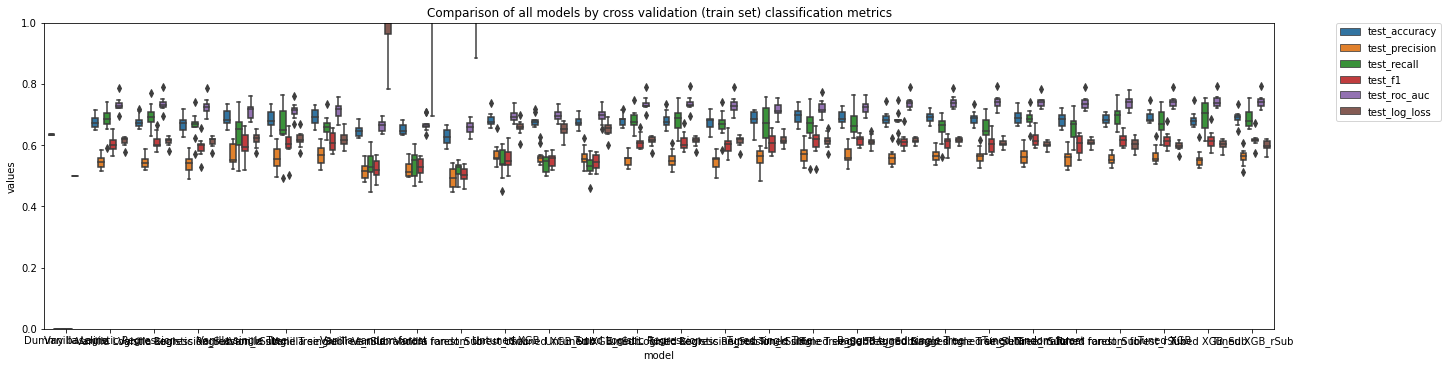

In [2080]:
# Show results for all models
plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plots)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Since we trained so many different models we will have to create multiple diagrams to compare them

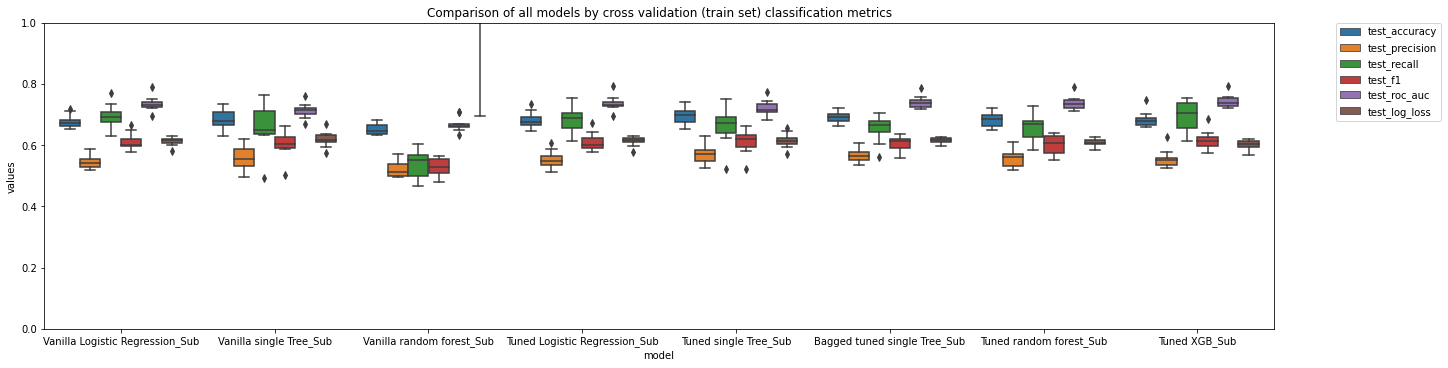

In [2081]:
# Show results for all models Sub and tuned
plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plots_Sub)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

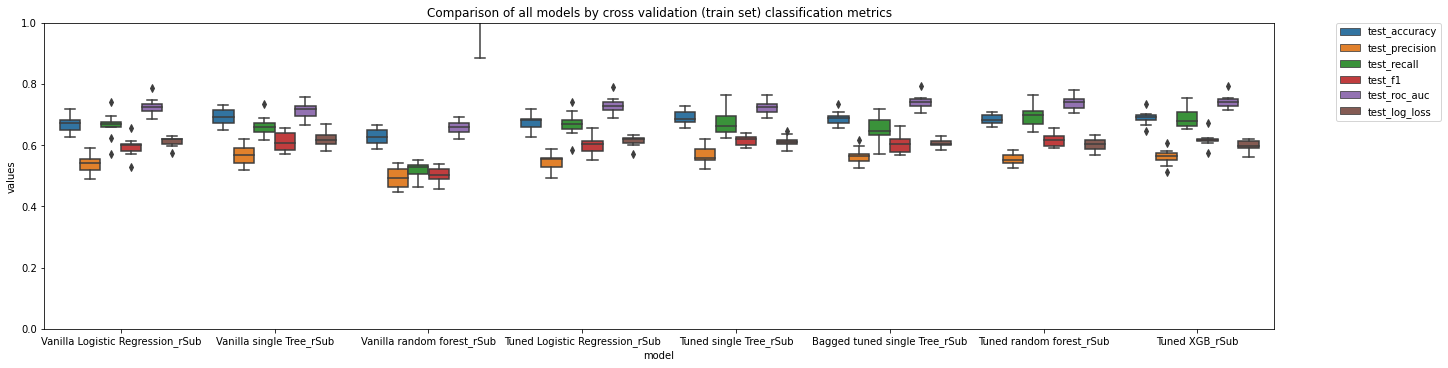

In [2082]:
# Show results for all models rSub and tuned
plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plots_rSub)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

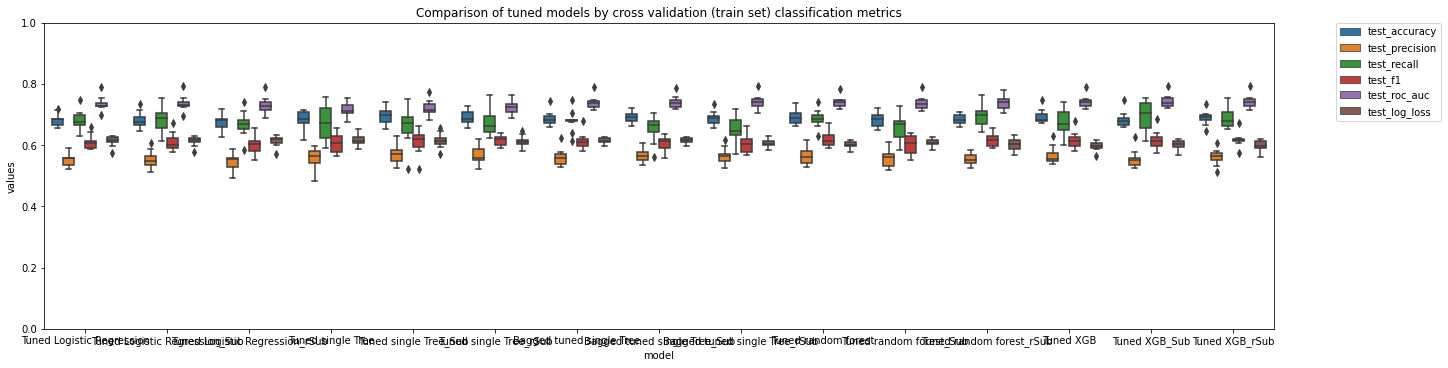

In [2009]:
#tuned_compl_sub = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
 #                              (~cv_results_plots["model"].str.contains('Vanilla')) &
  #                             (~cv_results_plots["model"].str.contains('Untuned'))]

#plt.figure(figsize=(20, 5), constrained_layout=True)
#sns.boxplot(x="model", y="values", hue="metrics", data=tuned_compl_sub)#, palette="Set3")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(0,1)
#plt.title('Comparison of tuned models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

### Models trained on complete Dataset

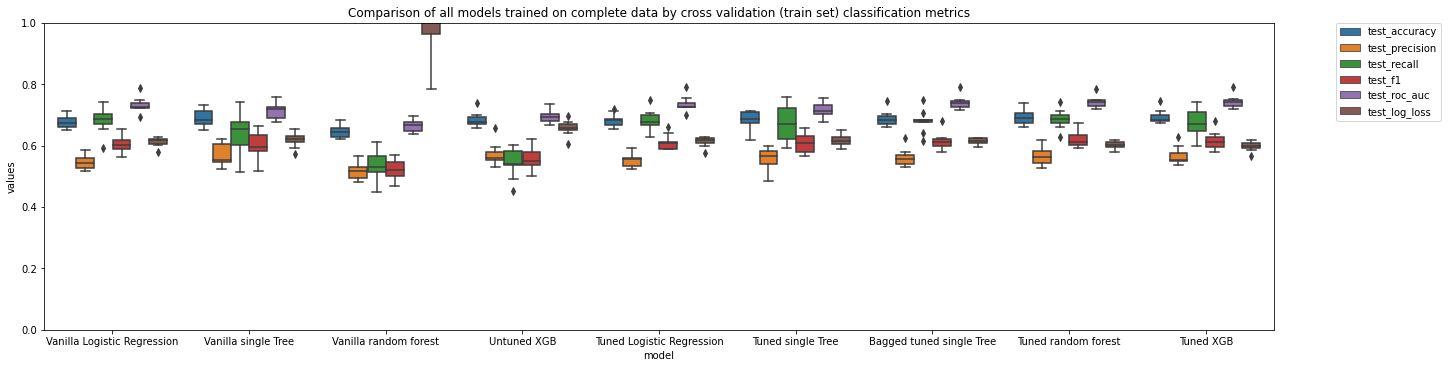

In [2084]:
# Show results only for all models trained on complete dataset
all_compl = cv_results_plots[(cv_results_plots["model"].str.contains('Vanilla|tuned|Tuned'))&
                               (~cv_results_plots["model"].str.contains('_Sub'))&
                               (~cv_results_plots["model"].str.contains('_rSub'))] #new line for rSub

plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=all_compl)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models trained on complete data by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Some explanations

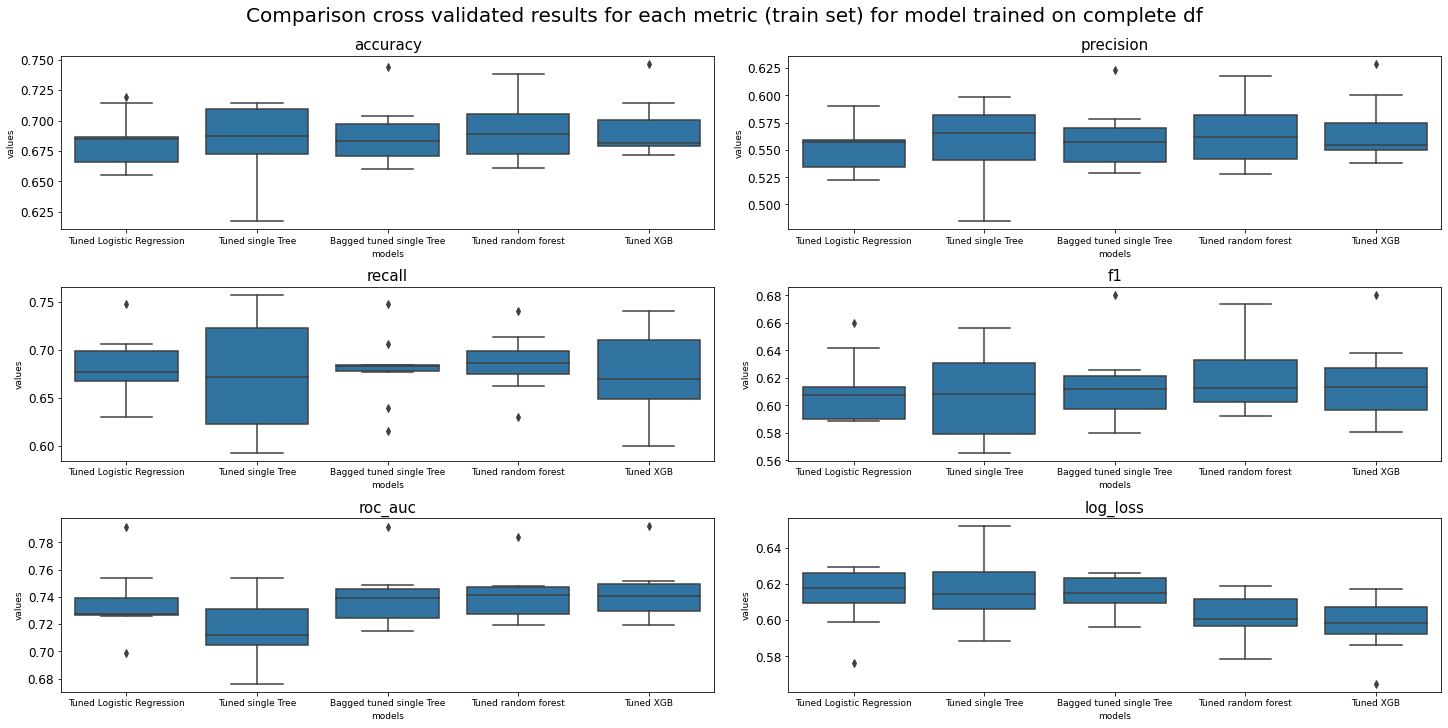

In [2085]:
# Compare only tuned model on comp dataset
tuned_compl = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
                               (~cv_results_plots["model"].str.contains('_Sub')) &
                               (~cv_results_plots["model"].str.contains('_rSub')) & #new line for rSub
                               (~cv_results_plots["model"].str.contains('Untuned'))]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for model trained on complete df', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(tuned_compl.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=tuned_compl[tuned_compl["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

### Models trained on subset


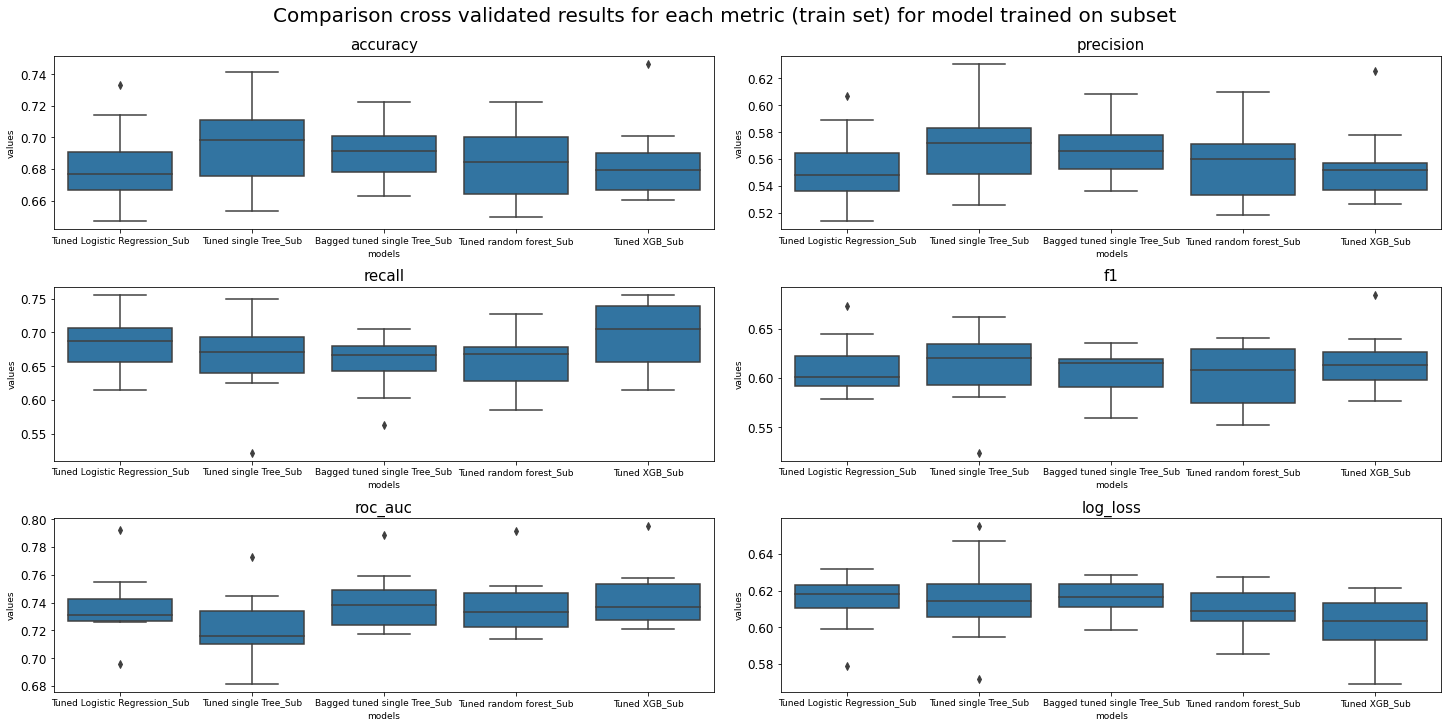

In [2012]:
# Compare only tuned model on subset dataset
tuned_sub = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
                               (cv_results_plots["model"].str.contains('_Sub')) &
                               (~cv_results_plots["model"].str.contains('Untuned'))]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for model trained on subset', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(tuned_sub.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=tuned_sub[tuned_sub["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

### Models trained on subset with race

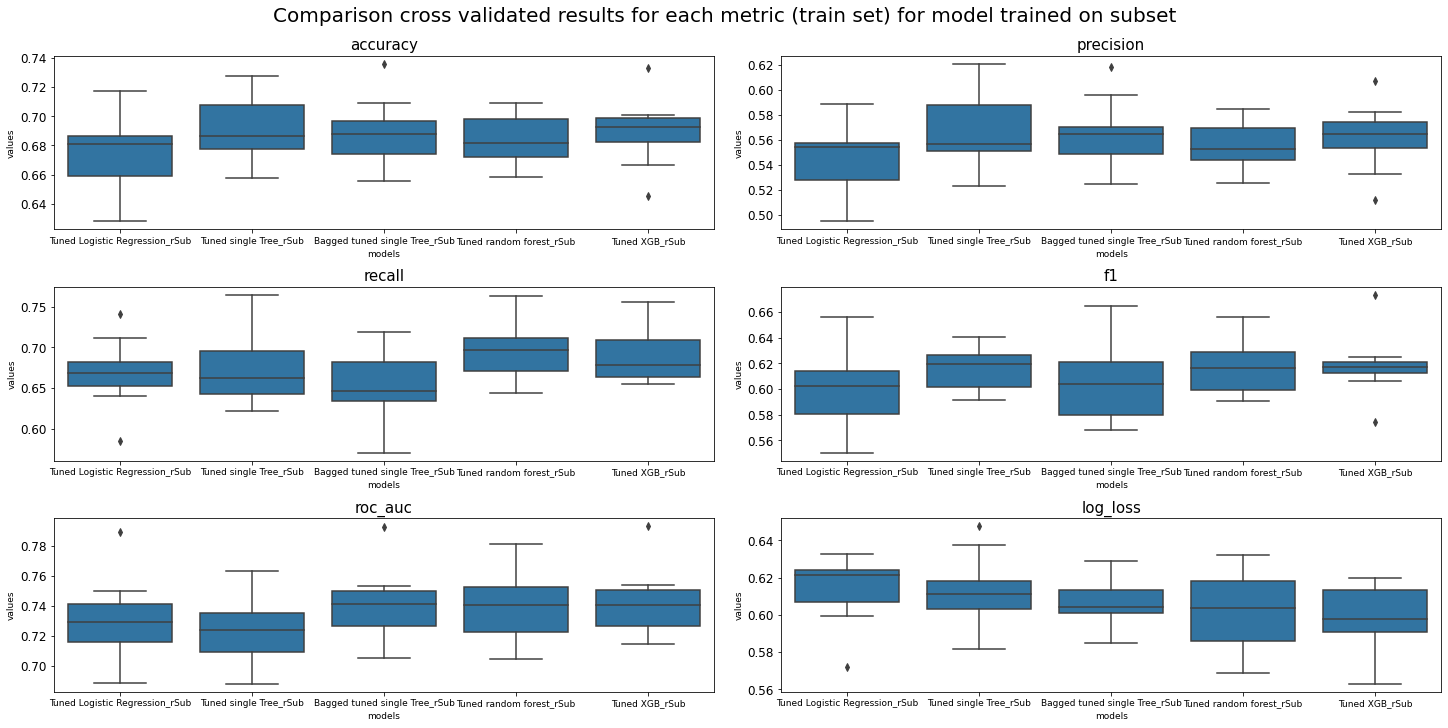

In [2086]:
# Compare only tuned model on race subset dataset
tuned_sub = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
                               (cv_results_plots["model"].str.contains('_rSub')) &
                               (~cv_results_plots["model"].str.contains('Untuned'))]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for model trained on subset', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(tuned_sub.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=tuned_sub[tuned_sub["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

### Side by side comparison for each model type 

In [2013]:
log_reg_models = [model for model in dict_models.keys() if 'Logistic' in model]
tree_models = [model for model in dict_models.keys() if 'single Tree' in model]
forest_models = [model for model in dict_models.keys() if 'random forest' in model]
XGB_models = [model for model in dict_models.keys() if 'XGB' in model]

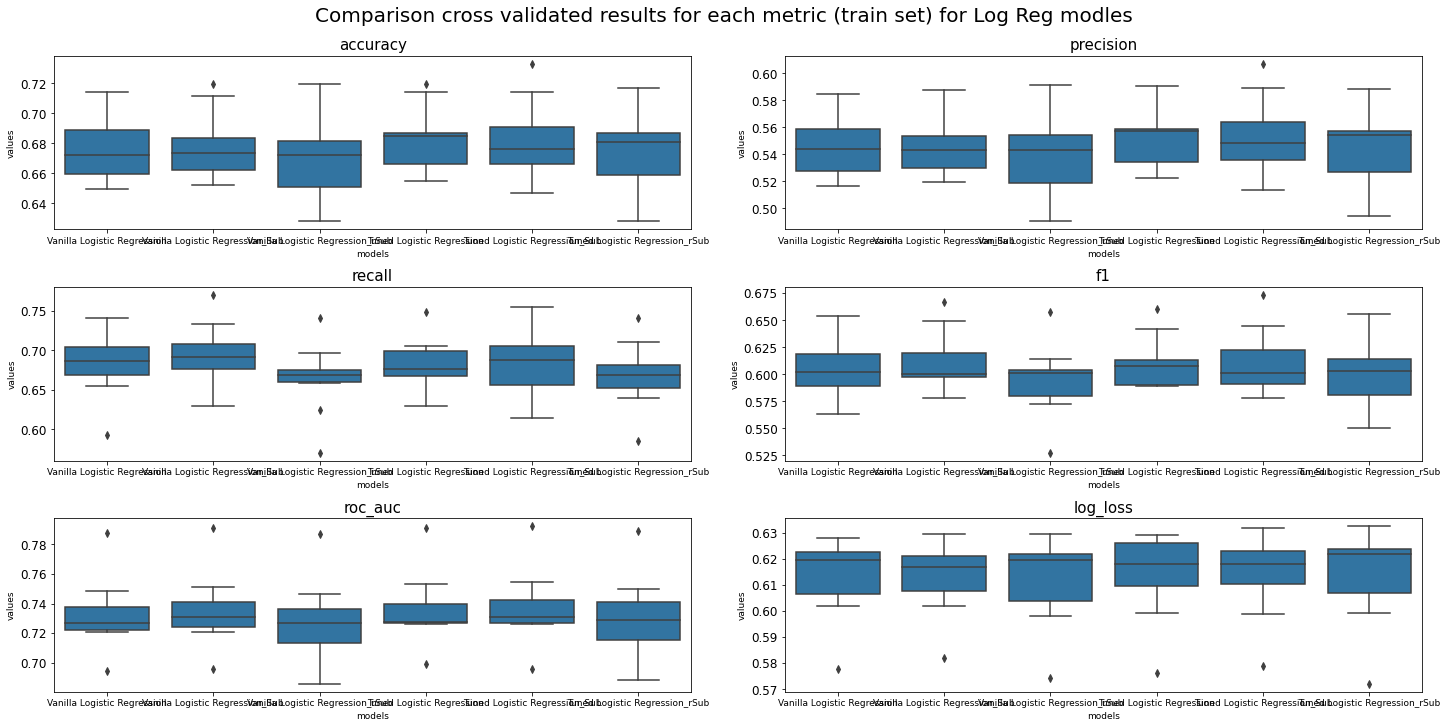

In [2014]:
# Logistic Regression models
log_reg = cv_results_plots[cv_results_plots["model"].isin(log_reg_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for Log Reg modles', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(log_reg.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=log_reg[log_reg["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

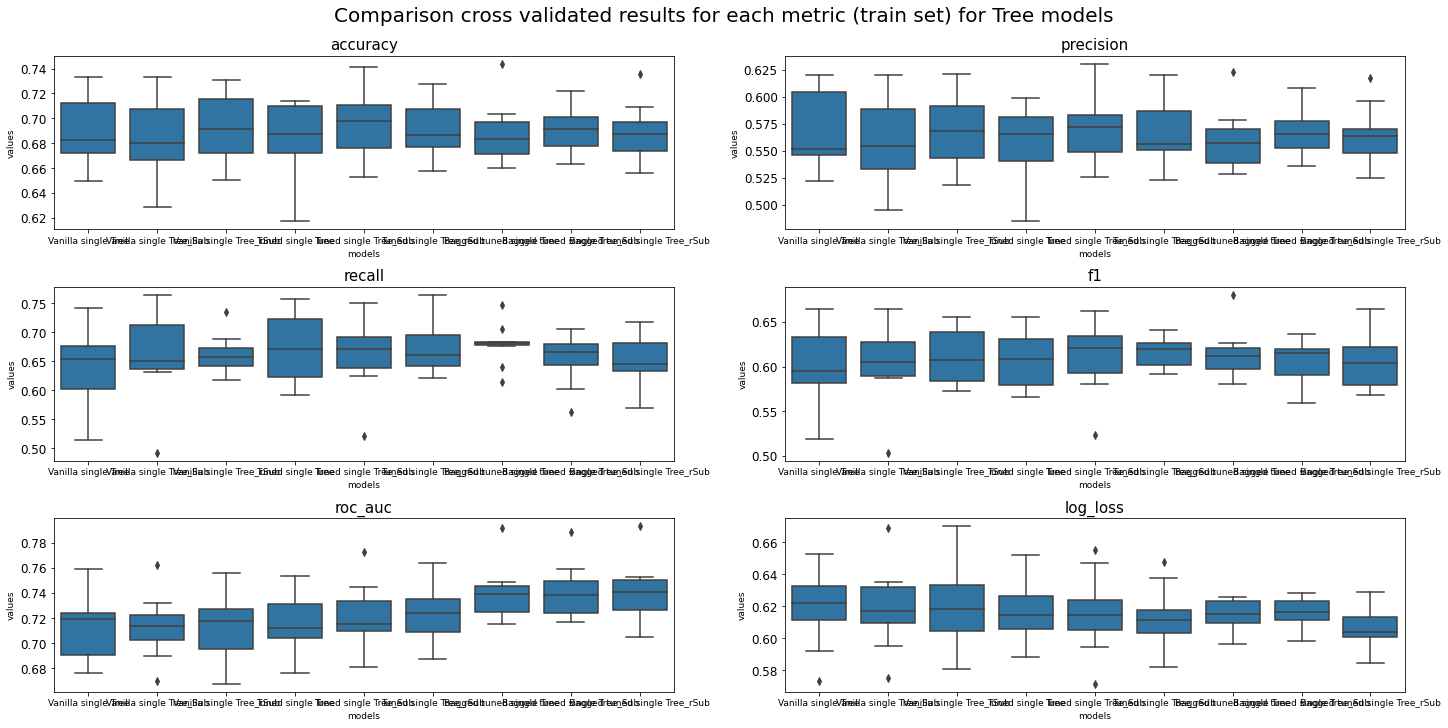

In [2015]:
# Trees
trees = cv_results_plots[cv_results_plots["model"].isin(tree_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for Tree models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(trees.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=trees[trees["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

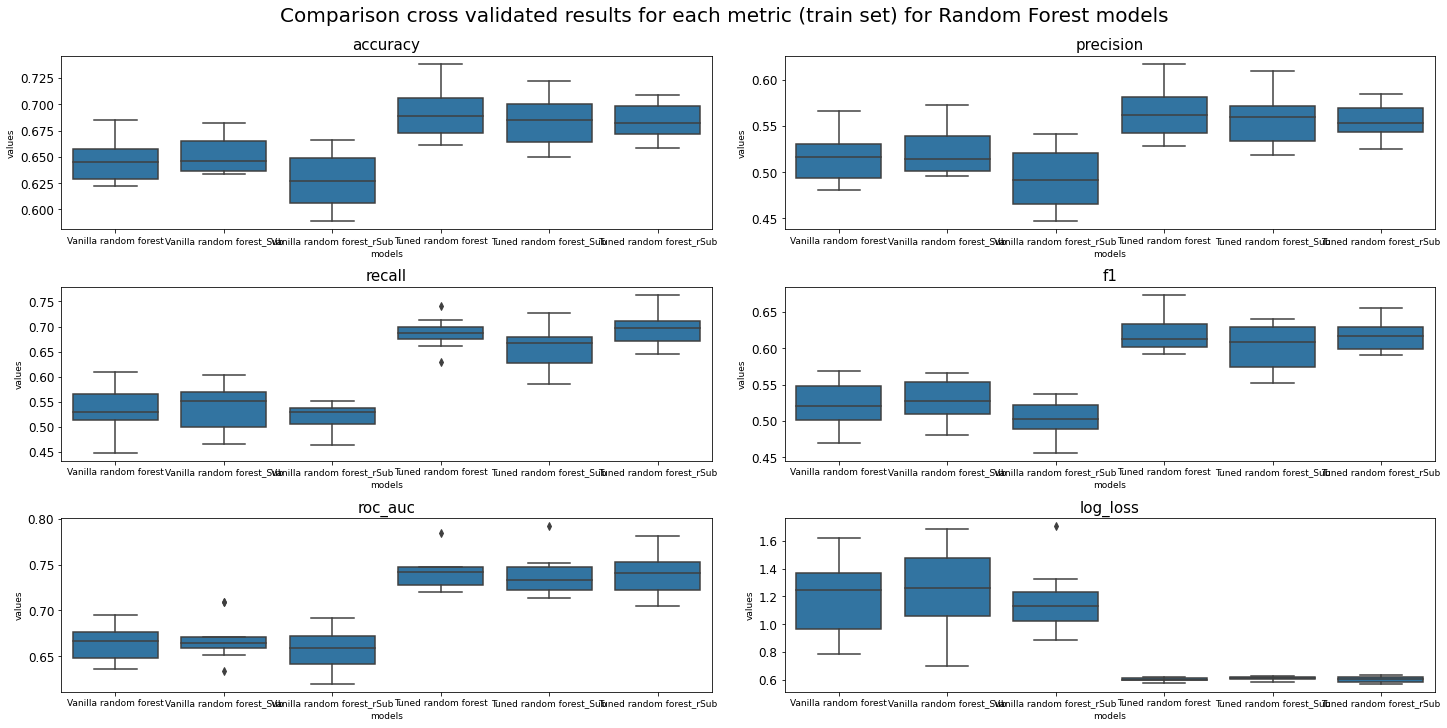

In [2016]:
# Forest models
forests = cv_results_plots[cv_results_plots["model"].isin(forest_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for Random Forest models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(forests.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=forests[forests["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

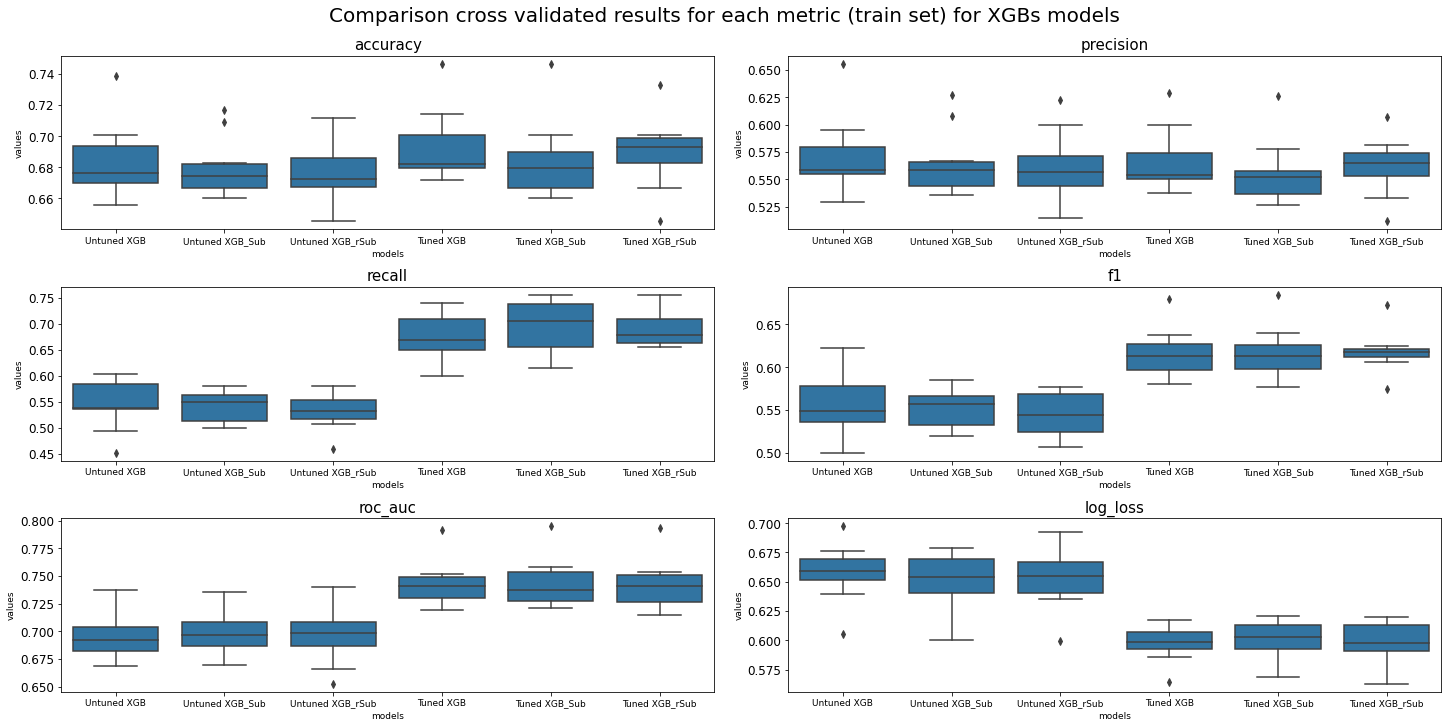

In [2017]:
# XGB models
XGBs = cv_results_plots[cv_results_plots["model"].isin(XGB_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for XGBs models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(XGBs.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=XGBs[XGBs["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

#### Comparision best models subset

In [2018]:
# Select best models and compare test scores
best_model_list = ["Tuned Logistic Regression_Sub", "Tuned single Tree_Sub", "Bagged tuned single Tree_Sub", "Tuned random forest_Sub", "Tuned XGB_Sub"]

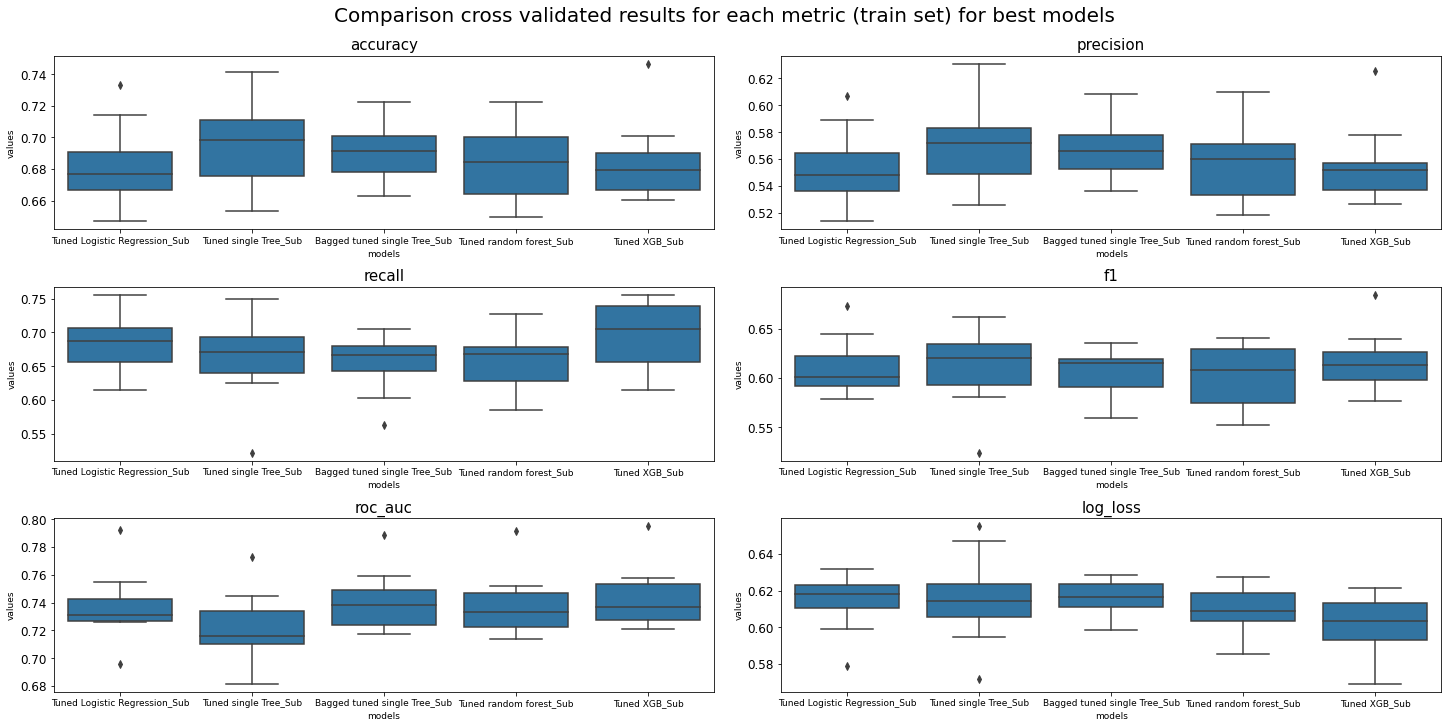

In [2019]:
# best models
best_models = cv_results_plots[cv_results_plots["model"].isin(best_model_list)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for best models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(best_models.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=best_models[best_models["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

#### Comparison best model with race subset

In [2089]:
# Select best models and compare test scores
best_model_list_rSub = ["Tuned Logistic Regression_rSub", "Tuned single Tree_rSub", "Bagged tuned single Tree_rSub", "Tuned random forest_rSub", "Tuned XGB_rSub"]

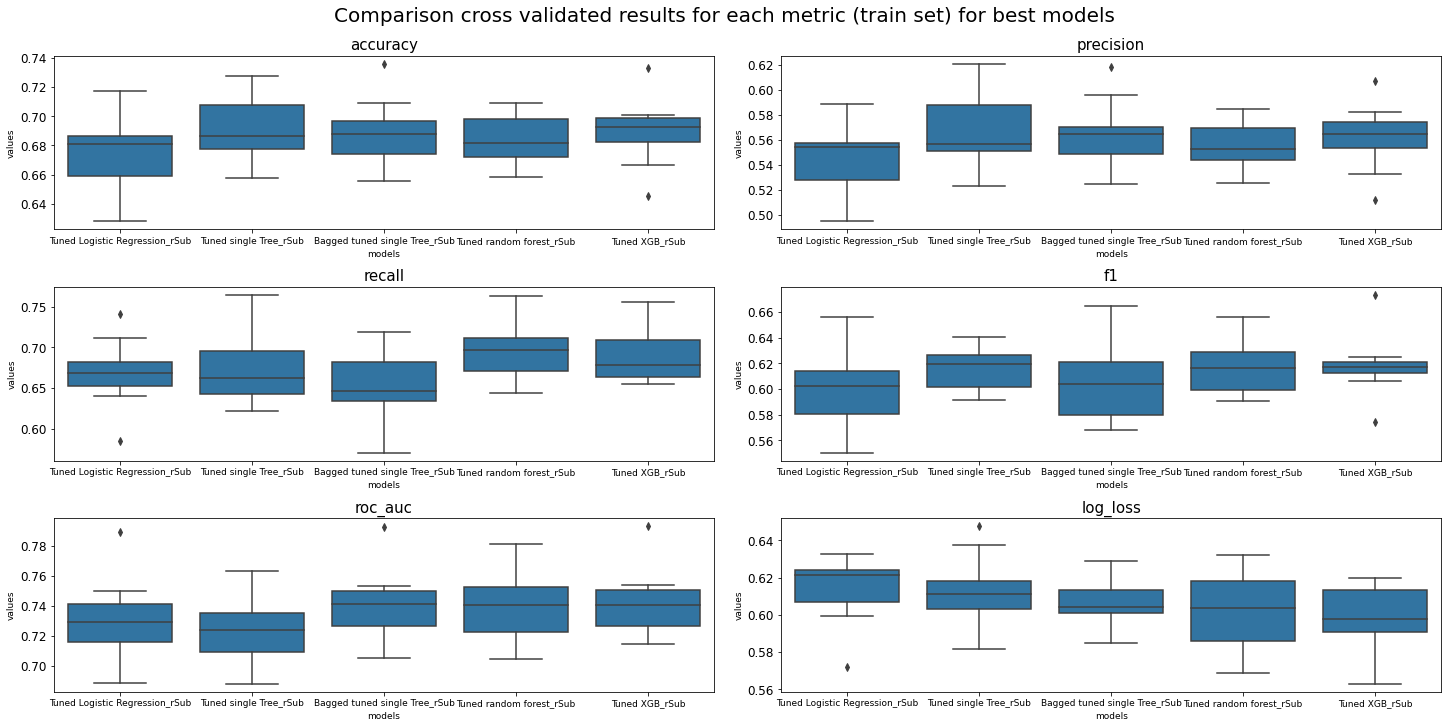

In [2090]:
# best models
best_models_rSub = cv_results_plots[cv_results_plots["model"].isin(best_model_list_rSub)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for best models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(best_models.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=best_models[best_models["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

## Calculate and compare test scores

### Models subset

In [2020]:
# Select best models and compare test scores
# Filter df for best models
dict_best = {nk: dict_models[nk] for nk in best_model_list}

In [2021]:
metrics_names = clf_scoring.copy()
metrics_names[-1]="log_loss"
test_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss]
metrics_dict = dict(zip(metrics_names, test_metrics))

In [2022]:
dict_test ={}
for me_name, metric in metrics_dict.items():
    test_scores = []
    for model in dict_best.values():
        if me_name=="log_loss":
            y_pred = model.predict_proba(X_test)
        else:
            y_pred = model.predict(X_test)
        test_scores.append(metric(y_test, y_pred))
    dict_test[me_name]=test_scores

In [2023]:
test_scores_df = pd.DataFrame(dict_test, index=best_model_list)
test_scores_df

,accuracy,precision,recall,f1,roc_auc,log_loss
Tuned Logistic Regression_Sub,0.673995,0.549107,0.630769,0.587112,0.664938,0.607938
Tuned single Tree_Sub,0.650126,0.518088,0.685470,0.590140,0.657531,0.619497
Bagged tuned single Tree_Sub,0.677764,0.552326,0.649573,0.597015,0.671857,0.614014
Tuned random forest_Sub,0.680276,0.555233,0.652991,0.600157,0.674559,0.607219
Tuned XGB_Sub,0.685302,0.563636,0.635897,0.597590,0.674950,0.596199


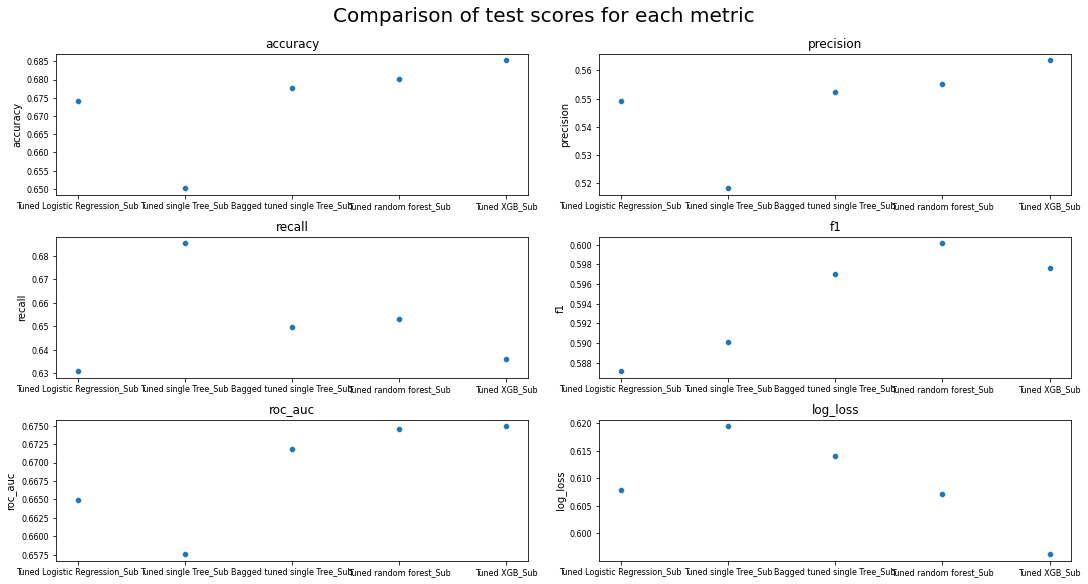

In [2024]:
#
fig, ax = plt.subplots(3,2, figsize=(15,8), constrained_layout=True)
fig.suptitle('Comparison of test scores for each metric', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(test_scores_df.columns):
    chart = sns.scatterplot(x=test_scores_df.index, y=metric, data=test_scores_df, ax=ax[i])    
    ax[i].tick_params(labelsize=8)
    ax[i].set_title(metric, fontsize=12)

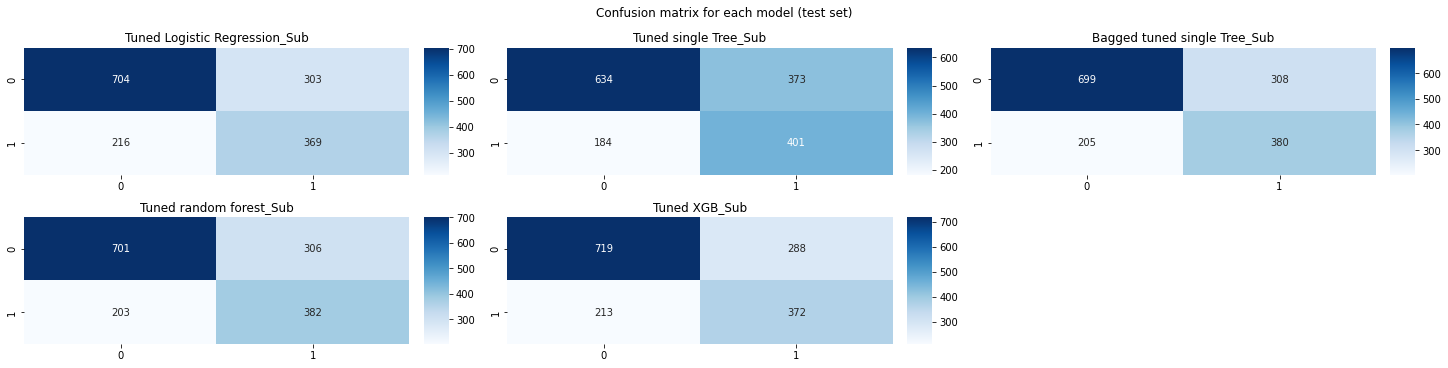

In [2025]:
# confusion matrixes
fig, ax = plt.subplots(2,3, figsize=(20,5), constrained_layout=True)
fig.suptitle('Confusion matrix for each model (test set)')
ax = ax.ravel()
ax[-1].set_visible(False)
i=0

for name, model in dict_best.items():
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, ax=ax[i], fmt='d', cmap='Blues')
    ax[i].set_title(name, fontsize=12)
    i+=1

In [2026]:
# Some explanaitons

### Models with race subset

In [2097]:
# Select best models and compare test scores
# Filter df for best models
dict_best = {nk: dict_models[nk] for nk in best_model_list_rSub} #rSub

In [2098]:
metrics_names = clf_scoring.copy()
metrics_names[-1]="log_loss"
test_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss]
metrics_dict = dict(zip(metrics_names, test_metrics))

In [2100]:
dict_test ={}
for me_name, metric in metrics_dict.items():
    test_scores = []
    for model in dict_best.values():
        if me_name=="log_loss":
            y_pred_race = model.predict_proba(X_test_race)
        else:
            y_pred_race = model.predict(X_test_race)
        test_scores.append(metric(y_test_race, y_pred_race))
    dict_test[me_name]=test_scores

In [2101]:
test_scores_df = pd.DataFrame(dict_test, index=best_model_list_rSub) #rSub
test_scores_df

,accuracy,precision,recall,f1,roc_auc,log_loss
Tuned Logistic Regression_rSub,0.662688,0.535503,0.618803,0.574148,0.653493,0.607375
Tuned single Tree_rSub,0.682161,0.558003,0.649573,0.600316,0.675333,0.615638
Bagged tuned single Tree_rSub,0.682161,0.558346,0.646154,0.599049,0.674616,0.603116
Tuned random forest_rSub,0.681533,0.557692,0.644444,0.597938,0.673761,0.599094
Tuned XGB_rSub,0.676508,0.550725,0.649573,0.596078,0.670864,0.597382


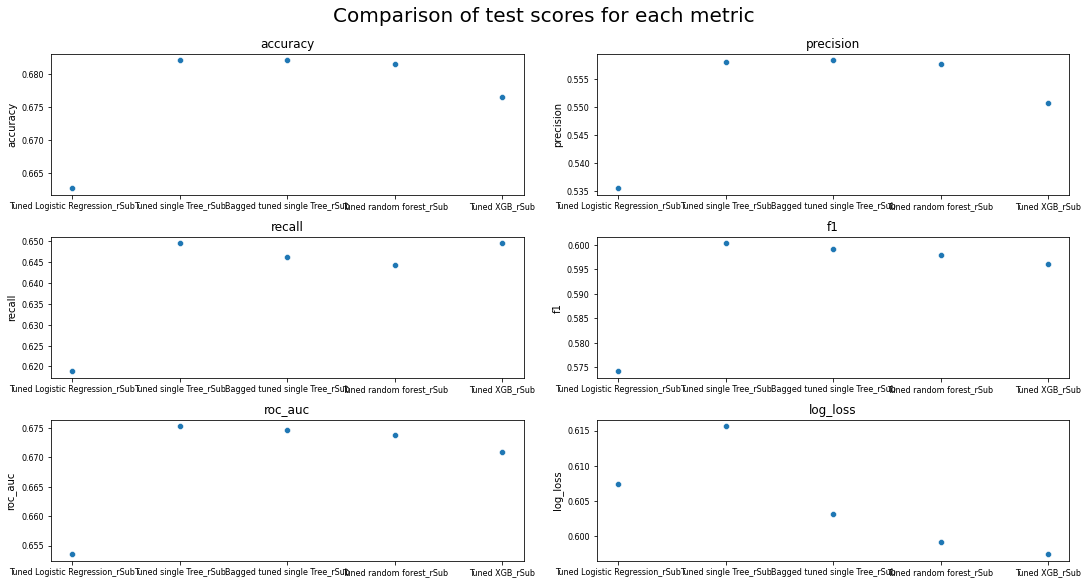

In [2102]:
#
fig, ax = plt.subplots(3,2, figsize=(15,8), constrained_layout=True)
fig.suptitle('Comparison of test scores for each metric', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(test_scores_df.columns):
    chart = sns.scatterplot(x=test_scores_df.index, y=metric, data=test_scores_df, ax=ax[i])    
    ax[i].tick_params(labelsize=8)
    ax[i].set_title(metric, fontsize=12)

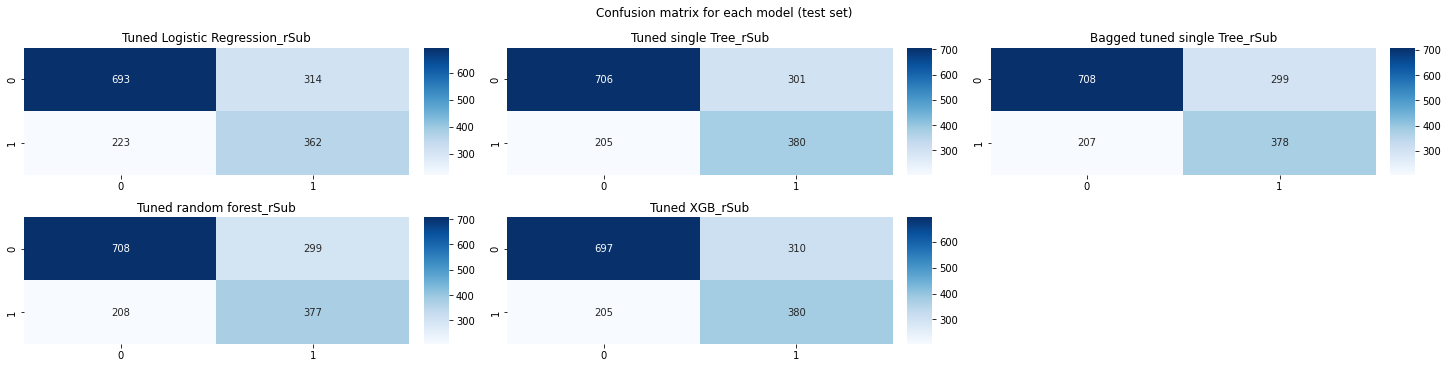

In [2104]:
# confusion matrixes
fig, ax = plt.subplots(2,3, figsize=(20,5), constrained_layout=True)
fig.suptitle('Confusion matrix for each model (test set)')
ax = ax.ravel()
ax[-1].set_visible(False)
i=0

for name, model in dict_best.items():
    y_pred_race = model.predict(X_test_race) #race
    cf_matrix = confusion_matrix(y_test_race, y_pred_race)
    sns.heatmap(cf_matrix, annot=True, ax=ax[i], fmt='d', cmap='Blues')
    ax[i].set_title(name, fontsize=12)
    i+=1

## Choose best estimator

In [2027]:
# Tuned XGB_sub as best estimator
best_estimator = dict_models["Tuned XGB_Sub"]
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               'M2',
                                                                                               'M1',
                                                                                               'F3',
                                                                                               'F2',
                                                                                               'F1']],
                                                                                  d...
                               gamma=0.5, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=30,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

# Explain best estimator

**Transform test data & reverse scaling for better interpretability**

In [2028]:
#apply the preprocessing to X_test
X_test_trans = pd.DataFrame(preproc_s.transform(X_test), columns=column_nam_sub)

In [2029]:
#reverse scaling for better interpretability of diagrams
X_test_unscaled = X_test_trans.copy()

#numerical features
X_test_unscaled[preproc_s.transformers_[0][2]]=preproc_s.transformers_[0][1][1].inverse_transform(X_test_trans[preproc_s.transformers_[0][2]])

#ordinal features
X_test_unscaled[preproc_s.transformers_[1][2]]=preproc_s.transformers_[1][1][2].inverse_transform(X_test_trans[preproc_s.transformers_[1][2]])

In [2030]:
X_test_unscaled.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
0,48.0,0.0,0.0,0.0,2.0,3.0,1.0
1,27.0,0.0,0.0,0.0,4.0,1.0,1.0
2,23.0,0.0,1.0,0.0,2.0,2.0,0.0


---

**MDI feature importance**

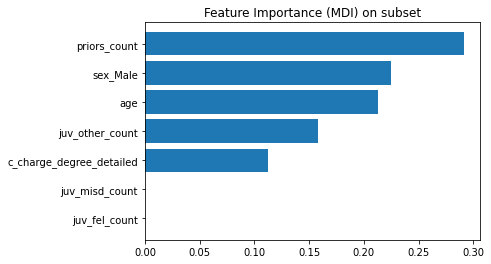

In [2031]:
#Check feature importance of best model
feature_importance_s = grid_XGB_s.best_estimator_.named_steps["xgbclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_s)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance_s[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_sub_trans.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on subset");


In [2032]:
# Best model only selected 5 out of 7 features 

## Shap values

In [2033]:
#load JS vis in the notebook
shap.initjs() 

In [2034]:
#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(best_estimator['xgbclassifier'])

In [2035]:
#get Shap values from preprocessed data
shap_values = explainer.shap_values(X_test_trans)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [2036]:
print(f"Shape of test data: {X_test_trans.shape}")
print(f"Shape of shap_values: {np.array(shap_values).shape}")

Shape of test data: (1592, 7)
Shape of shap_values: (1592, 7)


For classification problems, `explainer.shap_values()` return a list of size n_classes. Since this is a binary classification model n_classes=2. Each object of this list is an array of size [n_samples, n_features] and corresponds to the SHAP values for the respective class. In this example, shap_values[1] is the SHAP values for the positive class (recid in next two years = Yes) & shap_values[0] is the SHAP values for the negative class. 

## Global interpretability

### Variable Importance Plot

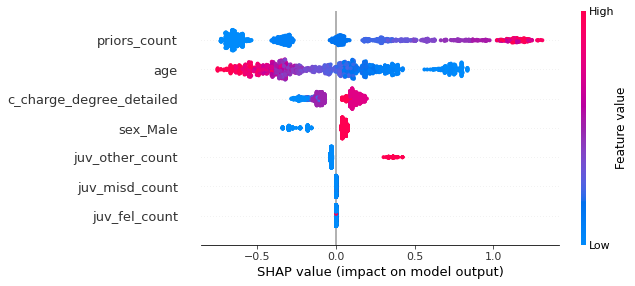

In [2037]:
# Shap values
shap.summary_plot(shap_values, X_test_trans)

### SHAP Partial Dependence Plot

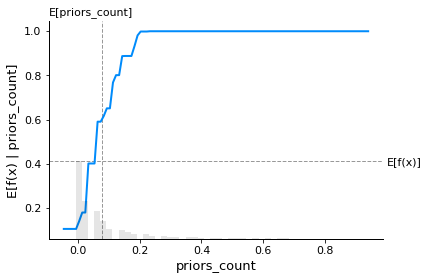

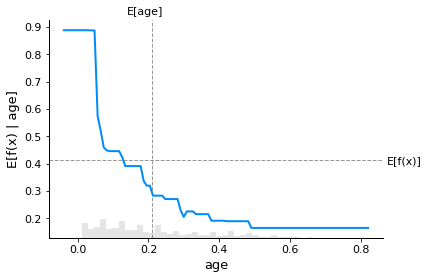

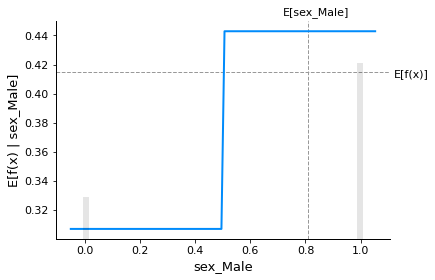

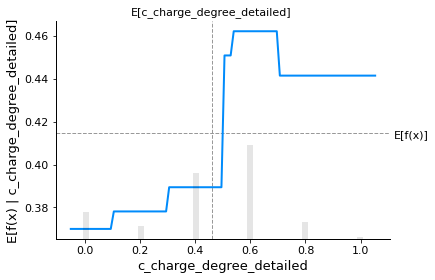

In [2038]:
features_list = ["priors_count", "age", "sex_Male", "c_charge_degree_detailed"]
for i in features_list:
    shap.plots.partial_dependence(
    i, best_estimator['xgbclassifier'].predict, X_test_trans.values, ice=False,
    model_expected_value=True, feature_expected_value=True, feature_names=X_test_trans.columns
    )

### SHAP Dependence Plot

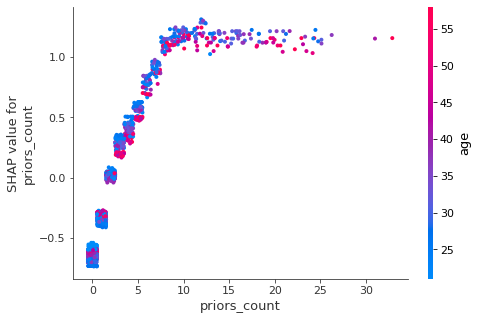

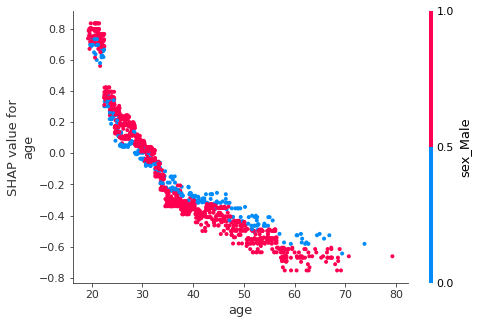

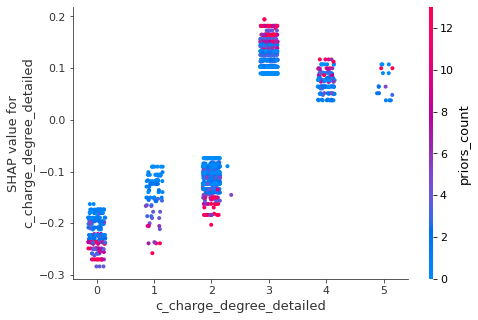

In [2039]:
features_list = ["priors_count","age", "c_charge_degree_detailed"]

for i, feature in enumerate(features_list):
    shap.dependence_plot(feature, shap_values, X_test_unscaled, x_jitter=10)

## Local Interpretability

### Individual SHAP Value Plot

In [2040]:
#Select random case from test data
np.random.seed(42)
rand_row = np.random.randint(0,X_test_unscaled.shape[0],1)
pd.concat([X_test_unscaled.iloc[rand_row,:],y_test[X_test_unscaled.iloc[rand_row,:].index]], axis=1)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
1126,25.0,0.0,0.0,0.0,0.0,2.0,1.0,0


In [2041]:
shap.force_plot(explainer.expected_value, shap_values[rand_row,:], features=X_test_unscaled.iloc[rand_row,:])

- terms contributing to push the model output from the base value (the average model output over the training dataset we used) to the model output. Terms pushing the prediction to higher log-odds values are shown in red, those pushing the prediction to lower log-odds values are in blue.

- Note that SHAP values are log-odds when using XGBoost with the logistic objective function. To convert log-odds margin to probability, we can use the formula odds = exp(log-odds) from which, p = odds/(1+odds).


In [2042]:
# Try understanding explainer.expected_value
j = rand_row[0]
log_odds = np.sum(shap_values[j])
avg_model_output = best_estimator.predict_proba(X_train)[:,1].mean() # prob
log_odds_avg_model_output = np.log(avg_model_output/(1-avg_model_output))
predicted_prob = best_estimator.predict_proba(X_test)[j][1] #target=1
predicted_log_odds = np.log(predicted_prob/(1-predicted_prob))
print("j:", j)
print("Sum of Shaphley values (log-odds) for j-instance:", log_odds, 
       'prob:', np.exp(log_odds)/(1.0+np.exp(log_odds)))
print("Average model output (Prob):", avg_model_output)
print("Predicted probability value for j-instance:", predicted_prob,
      "Predicted value:", best_estimator.predict(X_test)[j])
print('Shapley log_odds:', log_odds, 'is expected to be equal to pred-expected:', predicted_log_odds-explainer.expected_value)
print('pred-expected (prob):', explainer.expected_value)


j: 1126
Sum of Shaphley values (log-odds) for j-instance: -0.5646483 prob: 0.3624726364937746
Average model output (Prob): 0.47450626
Predicted probability value for j-instance: 0.35778755 Predicted value: 0
Shapley log_odds: -0.5646483 is expected to be equal to pred-expected: -0.5646483067301644
pred-expected (prob): -0.020331489


In [2043]:
# Check multiple samples (first 100 cases) at once

In [2044]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], features=X_test_unscaled.iloc[:100,:])

Let's look for some special cases and compare them with the truth

In [2045]:
ind= 18 # chosen basedn on multiple sample plot
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
18,56.0,0.0,0.0,0.0,9.0,0.0,1.0,0


In [2046]:
ind= 78 # chosen basedn on multiple sample plot
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
78,28.0,0.0,2.0,0.0,21.0,3.0,1.0,0


In [2047]:
ind= 39 # chosen basedn on multiple sample plot
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
39,24.0,0.0,0.0,0.0,8.0,3.0,1.0,0


In [2048]:
ind= 96 # chosen basedn on multiple sample plot
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
96,62.0,0.0,0.0,0.0,0.0,3.0,1.0,0


In [2049]:
ind= 11 # chosen basedn on multiple sample plot
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
11,41.0,0.0,0.0,0.0,4.0,2.0,1.0,1


In [2050]:
ind= 20 # chosen basedn on multiple sample plot
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
20,42.0,0.0,0.0,0.0,3.0,3.0,1.0,1


In [2051]:
ind= 34 # chosen basedn on multiple sample plot
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
34,69.0,0.0,0.0,0.0,22.0,1.0,1.0,0


In [2052]:
ind= 1362 # chosen basedn on max juv_misd count
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
1362,37.0,1.0,8.0,5.0,23.0,4.0,1.0,1


In [2053]:
ind= 342 # chosen basedn on max juv_fel count
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
342,36.0,10.0,0.0,0.0,14.0,3.0,1.0,1
